<a href="https://colab.research.google.com/github/rosebaekfany/Neuroscince/blob/main/HW04_Neuroscience_400110009_1401.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuroscience, Learning, Memory, Cognition Course
## Sharif University of Technology


In [ ]:
#@title Enter your information & "RUN the cell!!"
student_id =  400110009 #@param {type:"integer"}
student_name = "Zahra Maleki\"" #@param {type:"string"}

print("your student id:", student_id)
print("your name:", student_name)

your student id: 400110009
your name: Zahra Maleki"


#** PART I: Practical**

##Exercise Outline :
We got familiar with the stinmetz dataset in previous exercise. in this exercise we want to dig into the dataset more. please follow the description and helps given in each section.

## Import necessary packages


In [2]:
import numpy as np
import pickle
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib import patches, transforms, gridspec
from scipy.optimize import fsolve
from collections import namedtuple
from scipy.stats import zscore
from sklearn.decomposition import PCA
import pandas as pd
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectPercentile, f_classif



Mounted at /content/drive


# just run the cells below, these are some functions which help you through the process

In [3]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
from ipywidgets import GridspecLayout, HBox, VBox, FloatSlider, Layout, ToggleButtons
from ipywidgets import interactive, interactive_output, Checkbox, Select
from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

import warnings
warnings.filterwarnings("ignore")

In [4]:
# @title Plotting Functions

def plot_joint_probs(P, ):
    assert np.all(P >= 0), "probabilities should be >= 0"
    # normalize if not
    P = P / np.sum(P)
    marginal_y = np.sum(P,axis=1)
    marginal_x = np.sum(P,axis=0)

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    # start with a square Figure
    fig = plt.figure(figsize=(5, 5))

    joint_prob = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    rect_x_cmap = plt.cm.Blues
    rect_y_cmap = plt.cm.Reds

    # Show joint probs and marginals
    ax = fig.add_axes(joint_prob)
    ax_x = fig.add_axes(rect_histx, sharex=ax)
    ax_y = fig.add_axes(rect_histy, sharey=ax)

    # Show joint probs and marginals
    ax.matshow(P,vmin=0., vmax=1., cmap='Greys')
    ax_x.bar(0, marginal_x[0], facecolor=rect_x_cmap(marginal_x[0]))
    ax_x.bar(1, marginal_x[1], facecolor=rect_x_cmap(marginal_x[1]))
    ax_y.barh(0, marginal_y[0], facecolor=rect_y_cmap(marginal_y[0]))
    ax_y.barh(1, marginal_y[1], facecolor=rect_y_cmap(marginal_y[1]))
    # set limits
    ax_x.set_ylim([0,1])
    ax_y.set_xlim([0,1])

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{P[i,j]:.2f}"
        ax.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = marginal_x[i]
        c = f"{v:.2f}"
        ax_x.text(i, v +0.1, c, va='center', ha='center', color='black')
        v = marginal_y[i]
        c = f"{v:.2f}"
        ax_y.text(v+0.2, i, c, va='center', ha='center', color='black')

    # set up labels
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['Silver','Gold'])
    ax.set_yticklabels(['Small', 'Large'])
    ax.set_xlabel('color')
    ax.set_ylabel('size')
    ax_x.axis('off')
    ax_y.axis('off')
    return fig


def plot_prior_likelihood_posterior(prior, likelihood, posterior):

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.9
    padding = 0.12
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(12, 4))

    rect_prior = [left, bottom, small_width, height]
    rect_likelihood = [left_space , bottom , width, height]
    rect_posterior = [left_space +  added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_likelihood = fig.add_axes(rect_likelihood, sharey=ax_prior)
    ax_posterior = fig.add_axes(rect_posterior, sharey = ax_prior)

    rect_colormap = plt.cm.Blues

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = rect_colormap(prior[0, 0]))
    ax_prior.barh(1, prior[1], facecolor = rect_colormap(prior[1, 0]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.matshow(posterior, vmin=0., vmax=1., cmap='Greens')


    # Probabilities plot details
    # ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
    #              ylabel = 'state (s)', title = "Prior p(s)")
    ax_prior.set(xlim = [1, 0], xticks = [], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Prior p(s)")
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Likelihood p(m (left) | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details

    ax_posterior.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Posterior p(s | m)')
    ax_posterior.xaxis.set_ticks_position('bottom')
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)


    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{posterior[i,j]:.2f}"
        ax_posterior.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i, 0]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')


def plot_prior_likelihood(ps, p_a_s1, p_a_s0, measurement):
    likelihood = np.asarray([[p_a_s1, 1-p_a_s1],[p_a_s0, 1-p_a_s0]])
    assert 0.0 <= ps <= 1.0
    prior = np.asarray([ps, 1 - ps])
    if measurement == "Fish":
        posterior = likelihood[:, 0] * prior
    else:
        posterior = (likelihood[:, 1] * prior).reshape(-1)
    posterior /= np.sum(posterior)

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.9
    padding = 0.12
    small_width = 0.2
    left_space = left + small_width + padding
    small_padding = 0.05

    fig = plt.figure(figsize=(12, 4))

    rect_prior = [left, bottom, small_width, height]
    rect_likelihood = [left_space , bottom , width, height]
    rect_posterior = [left_space + width + small_padding, bottom , small_width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_likelihood = fig.add_axes(rect_likelihood, sharey=ax_prior)
    ax_posterior = fig.add_axes(rect_posterior, sharey=ax_prior)

    prior_colormap = plt.cm.Blues
    posterior_colormap = plt.cm.Greens

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = prior_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = prior_colormap(prior[1]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    # ax_posterior.matshow(posterior, vmin=0., vmax=1., cmap='')
    ax_posterior.barh(0, posterior[0], facecolor = posterior_colormap(posterior[0]))
    ax_posterior.barh(1, posterior[1], facecolor = posterior_colormap(posterior[1]))

    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Prior p(s)", xticks = [])
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details
    ax_posterior.set(xlim = [0, 1], xticks = [], yticks = [0, 1],
                     yticklabels = ['left', 'right'], title = "Posterior p(s | m)")
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    # for i,j in zip(x.flatten(), y.flatten()):
    #     c = f"{posterior[i,j]:.2f}"
    #     ax_posterior.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = posterior[i]
        c = f"{v:.2f}"
        ax_posterior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    return fig


from matplotlib import colors
def plot_utility(ps):
    prior = np.asarray([ps, 1 - ps])

    utility = np.array([[2, -3], [-2, 1]])

    expected = prior @ utility

    # definitions for the axes
    left, width = 0.05, 0.16
    bottom, height = 0.05, 0.9
    padding = 0.02
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(17, 3))

    rect_prior = [left, bottom, small_width, height]
    rect_utility = [left + added_space , bottom , width, height]
    rect_expected = [left + 2* added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_utility = fig.add_axes(rect_utility, sharey=ax_prior)
    ax_expected = fig.add_axes(rect_expected)

    rect_colormap = plt.cm.Blues

    # Data of plots
    ax_prior.barh(0, prior[0], facecolor = rect_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = rect_colormap(prior[1]))
    ax_utility.matshow(utility, cmap='cool')
    norm = colors.Normalize(vmin=-3, vmax=3)
    ax_expected.bar(0, expected[0], facecolor = rect_colormap(norm(expected[0])))
    ax_expected.bar(1, expected[1], facecolor = rect_colormap(norm(expected[1])))

    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], xticks = [], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Probability of state")
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Utility plot details
    ax_utility.set(xticks = [0, 1], xticklabels = ['left', 'right'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'action (a)',
                   title = 'Utility')
    ax_utility.xaxis.set_ticks_position('bottom')
    ax_utility.spines['left'].set_visible(False)
    ax_utility.spines['bottom'].set_visible(False)

    # Expected utility plot details
    ax_expected.set(title = 'Expected utility', ylim = [-3, 3],
                    xticks = [0, 1], xticklabels = ['left', 'right'],
                    xlabel = 'action (a)',
                    yticks = [])
    ax_expected.xaxis.set_ticks_position('bottom')
    ax_expected.spines['left'].set_visible(False)
    ax_expected.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)

    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{utility[i,j]:.2f}"
        ax_utility.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = expected[i]
        c = f"{v:.2f}"
        ax_expected.text(i, 2.5, c, va='center', ha='center', color='black')

    return fig


def plot_prior_likelihood_utility(ps, p_a_s1, p_a_s0, measurement):
    assert 0.0 <= ps <= 1.0
    assert 0.0 <= p_a_s1 <= 1.0
    assert 0.0 <= p_a_s0 <= 1.0
    prior = np.asarray([ps, 1 - ps])
    likelihood = np.asarray([[p_a_s1, 1-p_a_s1],[p_a_s0, 1-p_a_s0]])
    utility = np.array([[2.0, -3.0], [-2.0, 1.0]])
    # expected = np.zeros_like(utility)

    if measurement == "Fish":
        posterior = likelihood[:, 0] * prior
    else:
        posterior = (likelihood[:, 1] * prior).reshape(-1)
    posterior /= np.sum(posterior)
    # expected[:, 0] = utility[:, 0] * posterior
    # expected[:, 1] = utility[:, 1] * posterior
    expected = posterior @ utility

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.3
    padding = 0.12
    small_width = 0.2
    left_space = left + small_width + padding
    small_padding = 0.05

    fig = plt.figure(figsize=(10, 9))

    rect_prior = [left, bottom + height + padding, small_width, height]
    rect_likelihood = [left_space , bottom + height + padding , width, height]
    rect_posterior = [left_space + width + small_padding, bottom + height + padding , small_width, height]

    rect_utility = [padding, bottom, width, height]
    rect_expected = [padding + width + padding + left, bottom, width, height]

    ax_likelihood = fig.add_axes(rect_likelihood)
    ax_prior = fig.add_axes(rect_prior, sharey=ax_likelihood)
    ax_posterior = fig.add_axes(rect_posterior, sharey=ax_likelihood)
    ax_utility = fig.add_axes(rect_utility)
    ax_expected = fig.add_axes(rect_expected)

    prior_colormap = plt.cm.Blues
    posterior_colormap = plt.cm.Greens
    expected_colormap = plt.cm.Wistia

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = prior_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = prior_colormap(prior[1]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.barh(0, posterior[0], facecolor = posterior_colormap(posterior[0]))
    ax_posterior.barh(1, posterior[1], facecolor = posterior_colormap(posterior[1]))
    ax_utility.matshow(utility, vmin=0., vmax=1., cmap='cool')
    # ax_expected.matshow(expected, vmin=0., vmax=1., cmap='Wistia')
    ax_expected.bar(0, expected[0], facecolor = expected_colormap(expected[0]))
    ax_expected.bar(1, expected[1], facecolor = expected_colormap(expected[1]))

    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Prior p(s)", xticks = [])
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details
    ax_posterior.set(xlim = [0, 1], xticks = [], yticks = [0, 1],
                     yticklabels = ['left', 'right'], title = "Posterior p(s | m)")
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)

    # Utility plot details
    ax_utility.set(xticks = [0, 1], xticklabels = ['left', 'right'],
                   xlabel = 'action (a)', yticks = [0, 1], yticklabels = ['left', 'right'],
                   title = 'Utility', ylabel = 'state (s)')
    ax_utility.xaxis.set_ticks_position('bottom')
    ax_utility.spines['left'].set_visible(False)
    ax_utility.spines['bottom'].set_visible(False)

    # Expected Utility plot details
    ax_expected.set(ylim = [-2, 2], xticks = [0, 1], xticklabels = ['left', 'right'],
                 xlabel = 'action (a)', title = 'Expected utility', yticks=[])
    # ax_expected.axis('off')
    ax_expected.spines['left'].set_visible(False)
    # ax_expected.set(xticks = [0, 1], xticklabels = ['left', 'right'],
    #                 xlabel = 'action (a)',
    #                title = 'Expected utility')
    # ax_expected.xaxis.set_ticks_position('bottom')
    # ax_expected.spines['left'].set_visible(False)
    # ax_expected.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i in ind:
        v = posterior[i]
        c = f"{v:.2f}"
        ax_posterior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{utility[i,j]:.2f}"
        ax_utility.text(j,i, c, va='center', ha='center', color='black')
    # for i,j in zip(x.flatten(), y.flatten()):
    #     c = f"{expected[i,j]:.2f}"
    #     ax_expected.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = expected[i]
        c = f"{v:.2f}"
        ax_expected.text(i, v, c, va='center', ha='center', color='black')

    return fig

In [5]:
# @title Helper Functions

def compute_marginal(px, py, cor):
    """ Calculate 2x2 joint probabilities given marginals p(x=1), p(y=1) and correlation

      Args:
        px (scalar): marginal probability of x
        py (scalar): marginal probability of y
        cor (scalar): correlation value

      Returns:
        ndarray of size (2, 2): joint probability array of x and y
    """

    p11 = px*py + cor*np.sqrt(px*py*(1-px)*(1-py))
    p01 = px - p11
    p10 = py - p11
    p00 = 1.0 - p11 - p01 - p10

    return np.asarray([[p00, p01], [p10, p11]])


def compute_cor_range(px,py):
    """ Calculate the allowed range of correlation values given marginals p(x=1)
      and p(y=1)

    Args:
      px (scalar): marginal probability of x
      py (scalar): marginal probability of y

    Returns:
      scalar, scalar: minimum and maximum possible values of correlation
    """

    def p11(corr):
        return px*py + corr*np.sqrt(px*py*(1-px)*(1-py))
    def p01(corr):
        return px - p11(corr)
    def p10(corr):
        return py - p11(corr)
    def p00(corr):
        return 1.0 - p11(corr) - p01(corr) - p10(corr)
    Cmax = min(fsolve(p01, 0.0), fsolve(p10, 0.0))
    Cmin = max(fsolve(p11, 0.0), fsolve(p00, 0.0))
    return Cmin, Cmax

## Load the given dataset like previous exercise (This is not the full dataset, it includes recorded neurons from visual cortex)
load the data into "dat" using google drive like below or any other methods. *`3 Points`*

In [6]:
with open('/content/drive/MyDrive/Visual_Cortex_Stinmetz_Dataset.p', 'rb') as fp:
    dat = pickle.load(fp)

## Help Functions. You can use these functions to inspect the dataset


* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).



# Brain regions in the dataset
Take a look at brain_groups printed below. it indicates recorded areas in visual cortex, thalamus, and hippocampal region. Here in this section we need to seperate recording of each region.



In [10]:
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ]

You can inspect brain area for each neuron using dat['brain_area'] as below.

In [11]:
dat['brain_area']

array(['VISp', 'VISp', 'VISp', 'DG', 'VISp', 'VISp', 'SUB', 'DG', 'VISp',
       'VISp', 'SUB', 'DG', 'VISp', 'VISp', 'SUB', 'VISp', 'VISp', 'VISp',
       'SUB', 'SUB', 'DG', 'VISp', 'SUB', 'VISp', 'VISp', 'VISp', 'DG',
       'VISp', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'VISp',
       'VISp', 'SUB', 'VISp', 'DG', 'SUB', 'VISp', 'DG', 'SUB', 'SUB',
       'LGd', 'SUB', 'VISp', 'VISp', 'SUB', 'SUB', 'VISp', 'SUB', 'SUB',
       'DG', 'VISp', 'SUB', 'DG', 'VISp', 'VISp', 'SUB', 'VISp', 'LGd',
       'VISp', 'DG', 'SUB', 'SUB', 'DG', 'SUB', 'DG', 'VISp', 'LGd',
       'SUB', 'SUB', 'DG', 'SUB', 'SUB', 'SUB', 'DG', 'LGd', 'SUB', 'SUB',
       'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'DG', 'VISp', 'VISp', 'SUB',
       'SUB', 'SUB', 'VISp', 'SUB', 'VISp', 'DG', 'SUB', 'SUB', 'SUB',
       'VISp', 'SUB', 'SUB', 'SUB', 'DG', 'SUB', 'VISp', 'DG', 'SUB',
       'VISp', 'VISp', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB',
       'VISp', 'SUB', 'VISp', 'VISp', 'VISp', 'VISp', 'SUB', 'S

Please write a code to generate a list with same length of number of neurons to catagorize the brain regions in the dataset (0:visual cortex, 1:thalamus, 2:hippocampus, 3:others). For example the first neuron was recorded from 'VISp' which is in visual cortex region as indicated in brain_groups and therefore the first element in your list should be 0.
brain area list would be something like below:

barea = [0., 0., 0., 2., 0., 0., 2., 2., 0., 0., 2., 2., 0., 0., 2., 0., 0.,
        ...,
       2., 1., 0., 2., 0., 0., 2., 2., 1., 2., 1., 1., 1., 0., 0., 2., 1.]

*`10 Points`*

In [9]:
dat['brain_area']

array(['VISp', 'VISp', 'VISp', 'DG', 'VISp', 'VISp', 'SUB', 'DG', 'VISp',
       'VISp', 'SUB', 'DG', 'VISp', 'VISp', 'SUB', 'VISp', 'VISp', 'VISp',
       'SUB', 'SUB', 'DG', 'VISp', 'SUB', 'VISp', 'VISp', 'VISp', 'DG',
       'VISp', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'VISp',
       'VISp', 'SUB', 'VISp', 'DG', 'SUB', 'VISp', 'DG', 'SUB', 'SUB',
       'LGd', 'SUB', 'VISp', 'VISp', 'SUB', 'SUB', 'VISp', 'SUB', 'SUB',
       'DG', 'VISp', 'SUB', 'DG', 'VISp', 'VISp', 'SUB', 'VISp', 'LGd',
       'VISp', 'DG', 'SUB', 'SUB', 'DG', 'SUB', 'DG', 'VISp', 'LGd',
       'SUB', 'SUB', 'DG', 'SUB', 'SUB', 'SUB', 'DG', 'LGd', 'SUB', 'SUB',
       'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'DG', 'VISp', 'VISp', 'SUB',
       'SUB', 'SUB', 'VISp', 'SUB', 'VISp', 'DG', 'SUB', 'SUB', 'SUB',
       'VISp', 'SUB', 'SUB', 'SUB', 'DG', 'SUB', 'VISp', 'DG', 'SUB',
       'VISp', 'VISp', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB', 'SUB',
       'VISp', 'SUB', 'VISp', 'VISp', 'VISp', 'VISp', 'SUB', 'S

In [7]:
response = dat['response']
area = dat['brain_area']
barea = np.ndarray(shape = (dat['brain_area'].shape[0], ))

In [12]:
region_categories = []
i=0
for areaa in dat['brain_area']:
    if areaa in brain_groups[0] :
        barea[i] = 0
        region_categories.append(0)
    elif areaa in brain_groups[1]:
        barea[i] = 1
        region_categories.append(1)
    elif areaa in brain_groups[2]:
        barea[i] = 2
        region_categories.append(2)
    else:
        barea[i] = 3
        region_categories.append(3)
    i = i+1


## plots by brain region

Please illustrate brain region activity with respect to rat response type. You can use your acquired knowlwdge and codes from previous excercise. *`10 Points`*

In [13]:
# Define response types
left_resp_trials = np.where(dat['response'] == -1)[0]
right_resp_trials = np.where(dat['response'] == 1)[0]
no_right_stim_trials = np.where(dat['response'] == 0)[0]

# Define time bins
time = np.arange(dat['spks'].shape[2]) * 0.01

# Loop over brain regions
for i, area in enumerate(dat['brain_area']):
    # Categorize brain regions
    if area.startswith(("VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl")):
        category = 0
    elif area.startswith(("CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM")):
        category = 1
    elif area.startswith(("CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST")):
        category = 2
    else:
        category = 3

    # Get mean firing rates for each response type
    left_resp_firing_rate = np.mean(dat['spks'][category==i][:, left_resp_trials, :], axis=(0, 1))
    right_resp_firing_rate = np.mean(dat['spks'][category==i][:, right_resp_trials, :], axis=(0, 1))
    no_right_stim_firing_rate = np.mean(dat['spks'][category==i][:, no_right_stim_trials, :], axis=(0, 1))


In [ ]:
leftvis = 100*np.mean(dat['spks'][:, response == -1,:][barea == 0, :, :],axis=(0, 1))
nogovis = 100*np.mean(dat['spks'][:, response == 0,:][barea == 0, :, :],axis=(0, 1))
rightvis = 1100*np.mean(dat['spks'][:, response == 1,:][barea == 0, :, :],axis=(0, 1))

leftthal = 100*np.mean(dat['spks'][:, response == -1,:][barea == 1, :, :],axis=(0, 1))
nogothal = 100*np.mean(dat['spks'][:, response == 0,:][barea == 1, :, :],axis=(0, 1))
rightthal = 100*np.mean(dat['spks'][:, response == 1,:][barea == 1, :, :],axis=(0, 1))

leftresp = dat['spks'][:, response == -1,:][barea == 2, :, :]
nogoresp = dat['spks'][:, response == 0,:][barea == 2, :, :]
rightresp = dat['spks'][:, response == 1,:][barea == 2, :, :]

lefthip = 100*np.mean(dat['spks'][:, response == -1,:][barea == -1, :, :],axis=(0, 1))
nogohip = 100*np.mean(dat['spks'][:, response == 0,:][barea == -1, :, :],axis=(0, 1))
righthip = 100*np.mean(dat['spks'][:, response == 1,:][barea == -1, :, :],axis=(0, 1))

Text(0.5, 1.0, 'hipp')

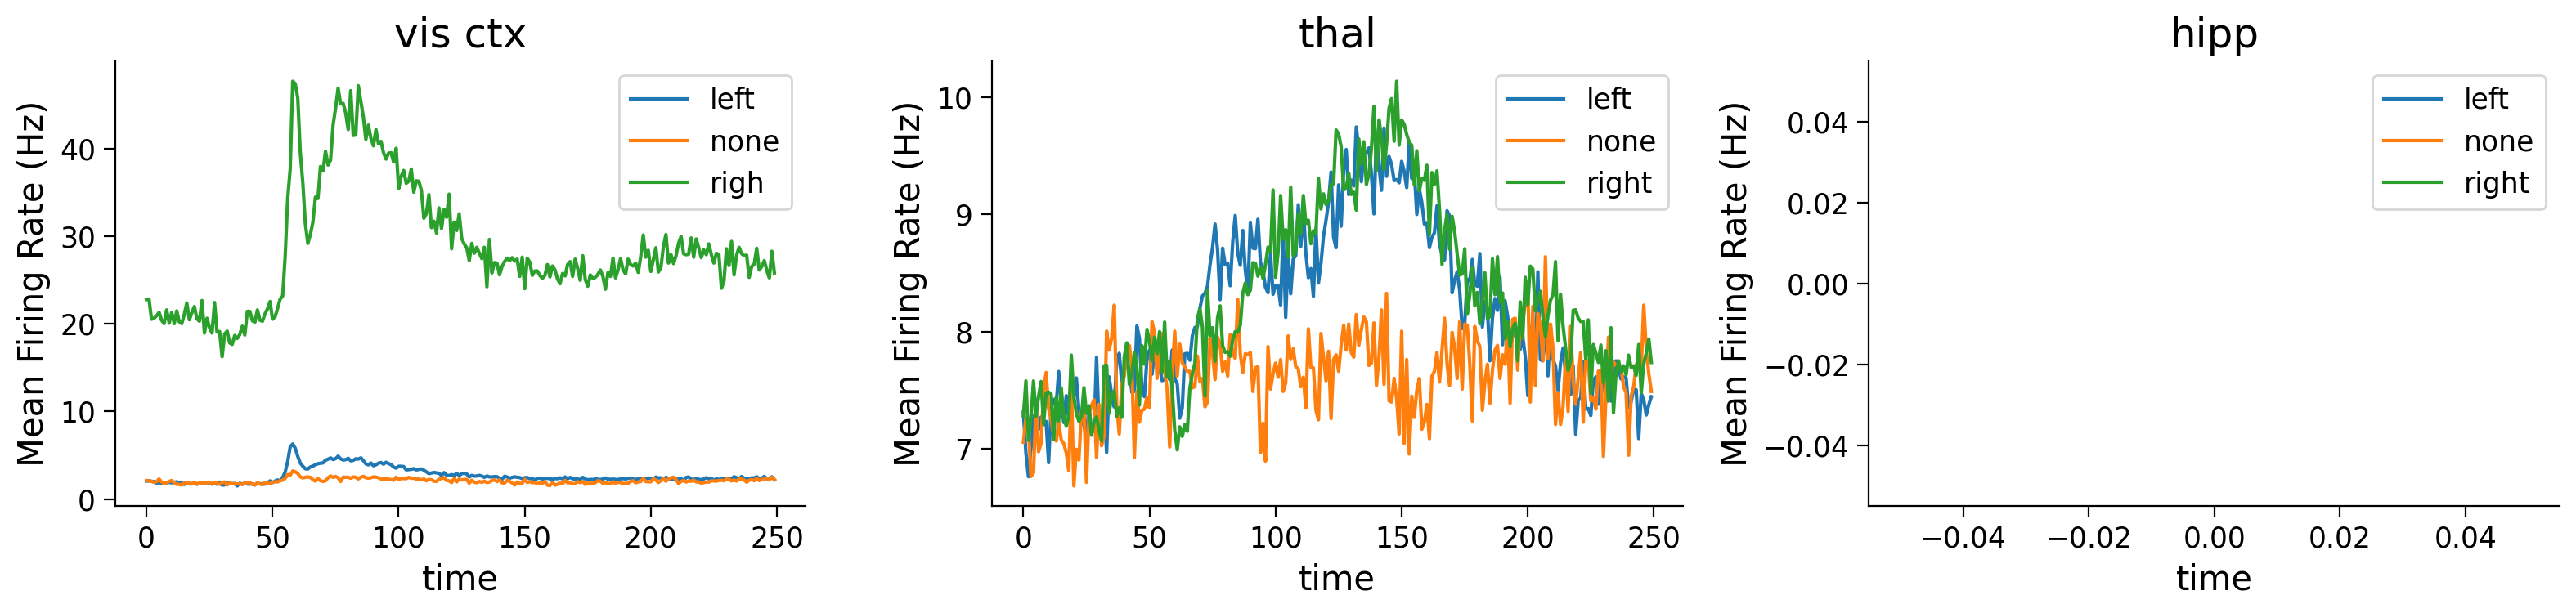

In [ ]:
plt.figure(figsize = (16,4))
time = np.arange(0,250,100*dat['bin_size'])
plt.subplot(131)
plt.plot(time, leftvis)
plt.plot(time, nogovis)
plt.plot(time, rightvis)
plt.legend(('left', 'none', 'righ'))
plt.xlabel('time')
plt.ylabel('Mean Firing Rate (Hz)')
plt.title('vis ctx')

plt.subplot(132)
plt.plot(time, leftthal)
plt.plot(time, nogothal)
plt.plot(time, rightthal)
plt.legend(('left', 'none', 'right'))
plt.xlabel('time')
plt.ylabel('Mean Firing Rate (Hz)')
plt.title('thal')

plt.subplot(133)
plt.plot(time, lefthip)
plt.plot(time, nogohip)
plt.plot(time, righthip)
plt.legend(('left', 'none', 'right'))
plt.xlabel('time')
plt.ylabel('Mean Firing Rate (Hz)')
plt.title('hipp')


You have to generate figures like below.
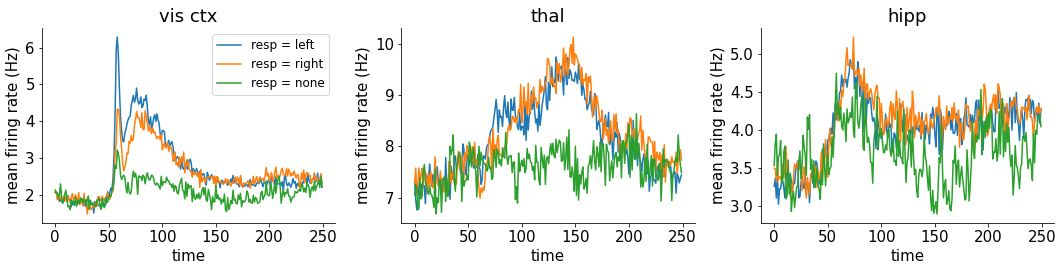

please ilustrate brain region activity with respect to visual conditions. You can use your acquired knowlwdge and codes from previous excercise. use dat['contrast_left'] and dat['contrast_right']
*`10 Points`*

In [ ]:
contrast_right = dat['contrast_right'];
contrast_left = dat['contrast_left'];

In [ ]:
right_stim = []
left_stim = []
neither_stim = []
both_stim = []

for i in range(0, response.shape[0]):
  if (contrast_right[i] > 0 and contrast_left[i] == 0):
    right_stim.append(dat['spks'][:,i,:])
  elif (contrast_right[i] == 0 and contrast_left[i] > 0):
    left_stim.append(dat['spks'][:,i,:])
  elif (contrast_right[i] == 0 and contrast_left[i] == 0):
    neither_stim.append(dat['spks'][:,i,:])
  else:
    both_stim.append(dat['spks'][:,i,:])

In [ ]:
right_stim = np.moveaxis(np.asarray(right_stim), 0, 1)
left_stim = np.moveaxis(np.asarray(left_stim), 0, 1)
neither_stim = np.moveaxis(np.asarray(neither_stim), 0, 1)
both_stim = np.moveaxis(np.asarray(both_stim), 0, 1)

In [ ]:
def av(n):
    return sum(n) / len(n)

left_vis = av(av(left_stim[barea == 0, :, :]));
neither_vis = av(av(neither_stim[barea == 0, :, :]));
right_vis = av(av(right_stim[barea == 0, :, :]));
both_vis = av(av(both_stim[barea == 0, :, :]));

left_thal = av(av(left_stim[barea == 1, :, :]));
neither_thal = av(av(neither_stim[barea == 1, :, :]));
right_thal = av(av(right_stim[barea == 1, :, :]));
both_thal = av(av(both_stim[barea == 1, :, :]));

left_hipp = av(av(left_stim[barea == 2, :, :]));
neither_hipp = av(av(neither_stim[barea == 2, :, :]));
right_hipp = av(av(right_stim[barea == 2, :, :]));
both_hipp = av(av(both_stim[barea == 2, :, :]));


Text(0.5, 1.0, 'hipp')

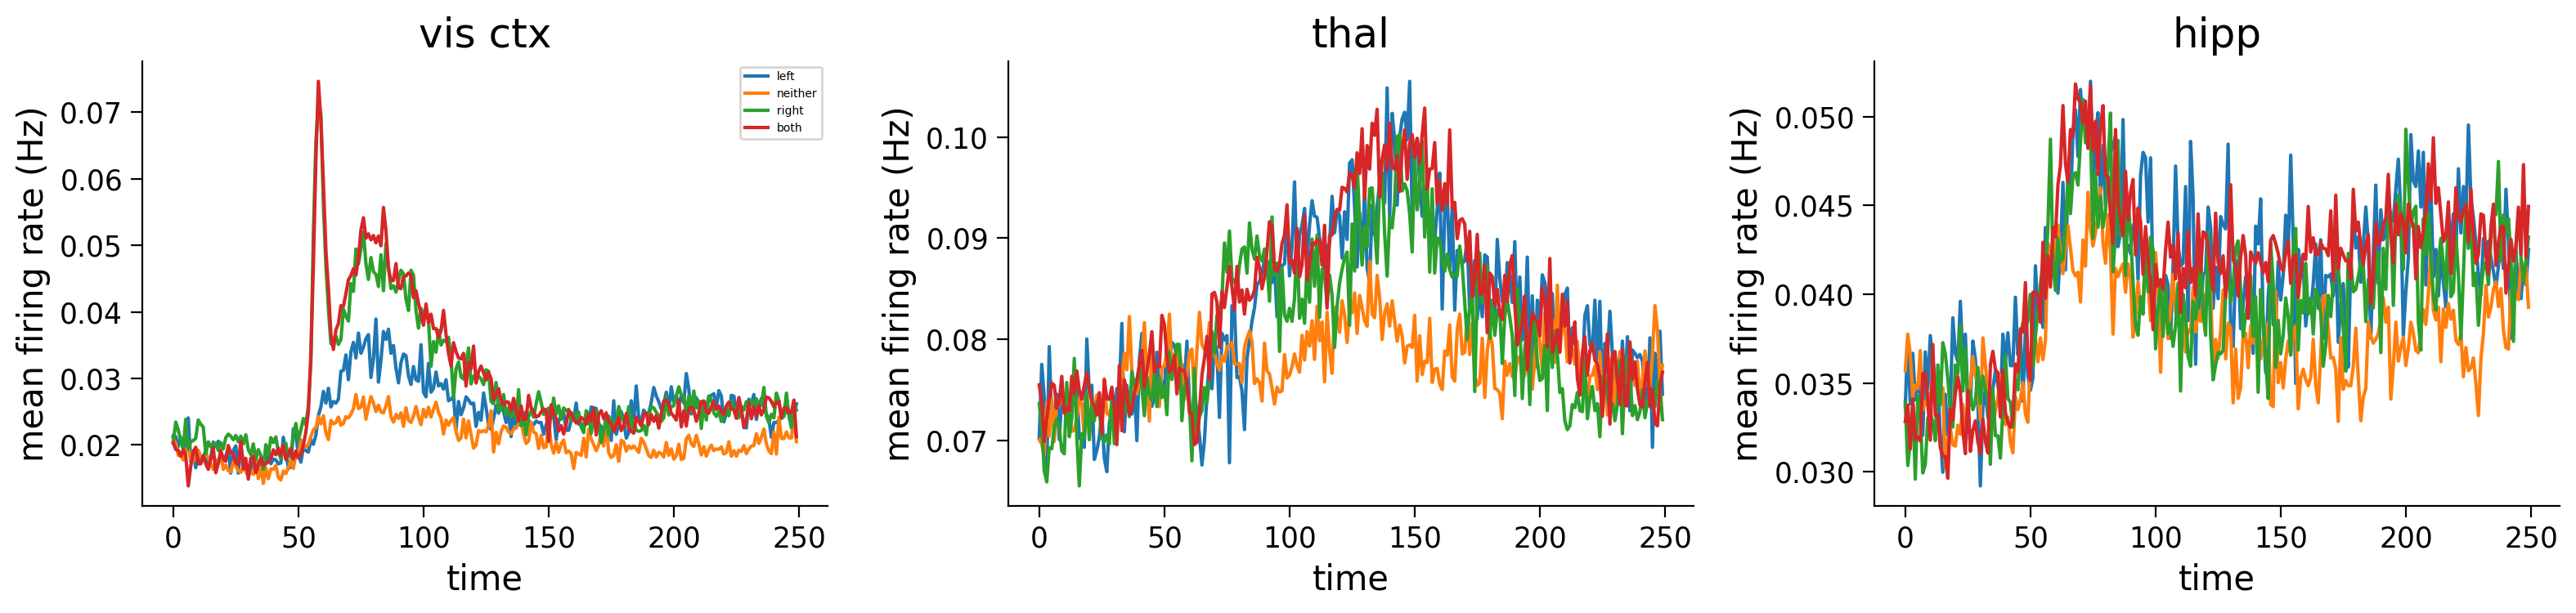

In [ ]:
time = np.arange(0,250,100*dat['bin_size'])
plt.figure(figsize = (16,4))

plt.subplot(131)
plt.plot(time, left_vis)
plt.plot(time, neither_vis)
plt.plot(time, right_vis)
plt.plot(time, both_vis)
plt.legend(('left', 'neither', 'right ', 'both'), fontsize = 5)
plt.xlabel('time')
plt.ylabel('mean firing rate (Hz)')
plt.title('vis ctx')

plt.subplot(132)
plt.plot(time, left_thal)
plt.plot(time, neither_thal)
plt.plot(time, right_thal)
plt.plot(time, both_thal)
plt.xlabel('time')
plt.ylabel('mean firing rate (Hz)')
plt.title('thal')

plt.subplot(133)
plt.plot(t, left_hipp)
plt.plot(t, neither_hipp)
plt.plot(t, right_hipp)
plt.plot(t, both_hipp)
plt.xlabel('time')
plt.ylabel('mean firing rate (Hz)')
plt.title('hipp')


You have to generate figures like below. 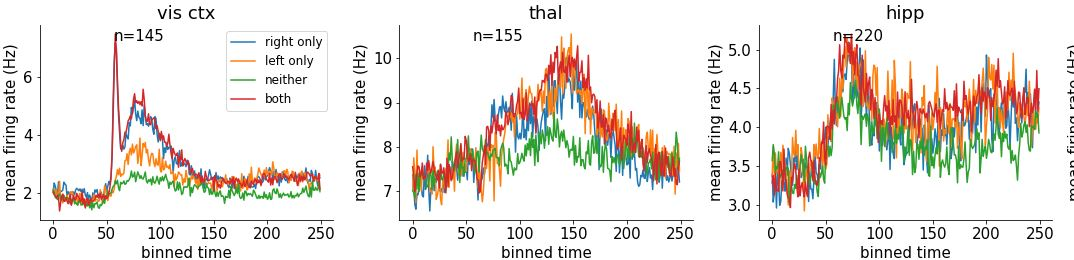

What can you infer by comparing these six figures? alo compare regions, it seems that hippocampus is somehow moving average of visual cortex? find some correlation between regions and discuss in your report. *`10 Points`*

## PCA (Principle Component Analysis)

In this section you should implement PCA analysis on neural data and inspect the 5 top principle components(PCs). follow steps below:
* select 51-130 bins from dat['spks'] which indicates the stimulus + response period.
* reshape the selected bin to (number of neuron, -1)
* normalize the matrix by reducing its average over axis = 1
* transpose the data
* run PC analysis with PCA function from sklearn package with n_components = 5 and fit that to the dataset

*`15 Points`*

In [ ]:
NN = dat['spks'].shape[0]
data = dat['spks'][:, :, 51:130]
data = np.reshape(data, (NN, -1))
avg =  np.mean(data, axis = 1)
data = data - avg[:, np.newaxis]
data = data.T
model = PCA(5)
model.fit(data)
W = model.components_
pc = W @ np.reshape(dat['spks'], (NN, -1))
pc = np.reshape(pc, (5, -1, dat['spks'].shape[-1]))

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

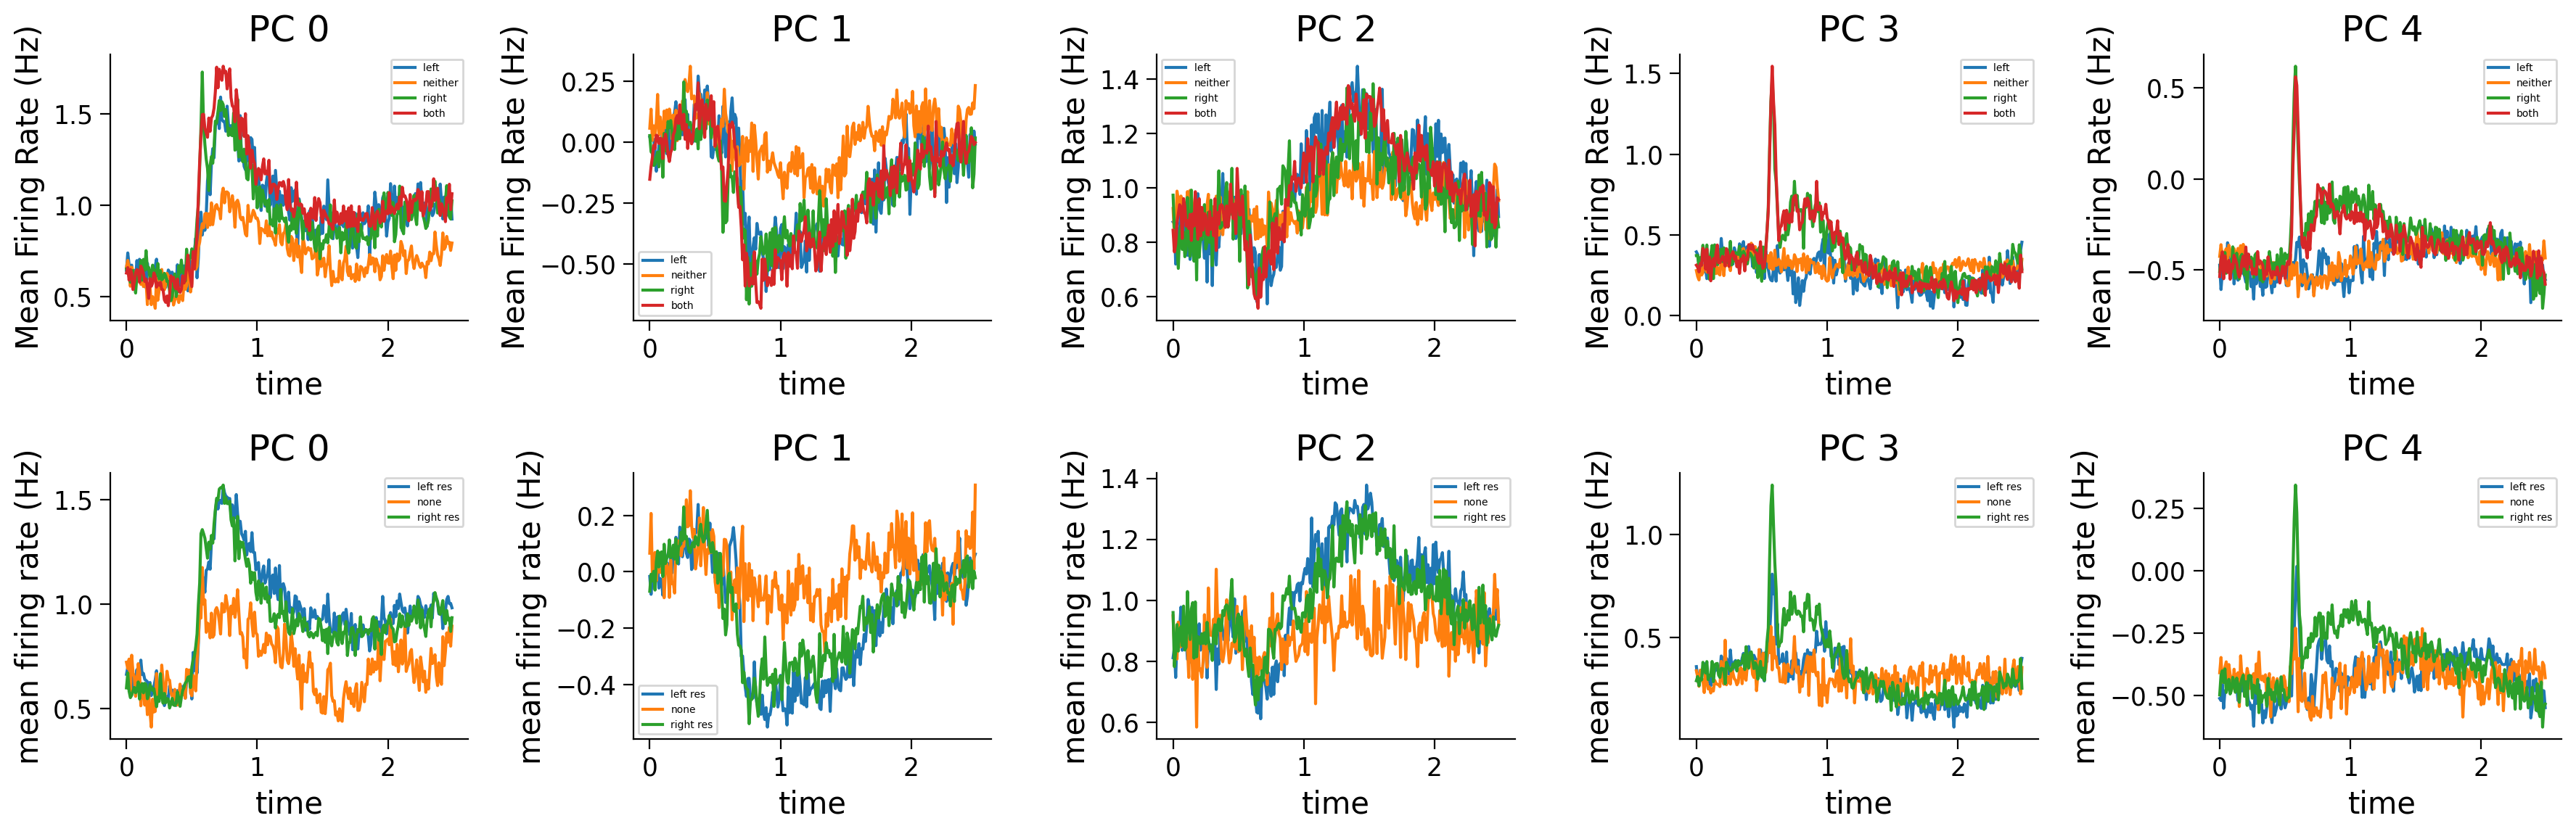

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(pc.shape[0]):

    left_resp = np.mean(pc[i, response == 1,:], axis=0);
    nogo_resp = np.mean(pc[i, response == 0,:], axis=0);
    right_resp = np.mean(pc[i, response == -1,:], axis=0);

    right_stim = []
    left_stim = []
    neither_stim = []
    both_stim = []

    for h in range(0, response.shape[0]):
      if (contrast_right[h] > 0 and contrast_left[h] == 0):
        right_stim.append(pc[i,h,:])
      elif (contrast_right[h] == 0 and contrast_left[h] > 0):
        left_stim.append(pc[i,h,:])
      elif (contrast_right[h] == 0 and contrast_left[h] == 0):
        neither_stim.append(pc[i,h,:])
      else:
        both_stim.append(pc[i,h,:])

    left_stim = np.mean(np.asarray(left_stim), axis = 0)
    right_stim = np.mean(np.asarray(right_stim), axis = 0)
    neither_stim = np.mean(np.asarray(neither_stim), axis = 0)
    both_stim = np.mean(np.asarray(both_stim), axis = 0)

    time = np.arange(0,2.5,dat['bin_size'])
    plt.subplot2grid((2,5), (0, i))
    plt.plot(time, left_stim)
    plt.plot(time, neither_stim)
    plt.plot(time, right_stim)
    plt.plot(time, both_stim)
    plt.legend(('left ', 'neither', 'right ', 'both'), fontsize = 5)
    plt.xlabel('time')
    plt.ylabel('Mean Firing Rate (Hz)')
    plt.title(f'PC {i}')

    plt.subplot2grid((2,5), (1, i))
    plt.plot(time, left_resp)
    plt.plot(time, nogo_resp)
    plt.plot(time, right_resp)
    plt.legend(('left res', 'none', 'right res'), fontsize = 5)
    plt.xlabel('time')
    plt.ylabel('mean firing rate (Hz)')
    plt.title(f'PC {i}')

pc.shape = (5, 340, 250)
after computing pc variable, we need to plot the first 5 PCs with regards to visual conditions and response type as we did in previous section. please generate figures like below:
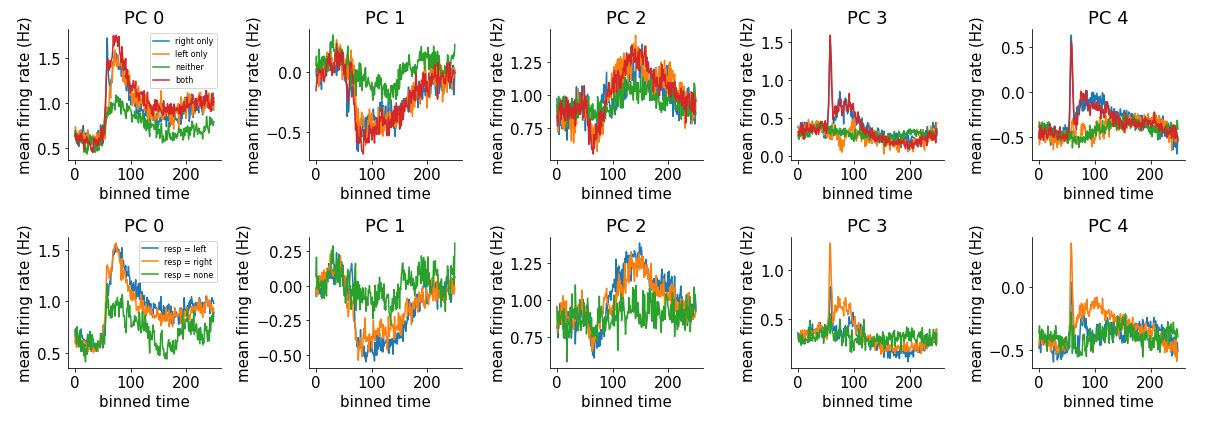

This is not completed yet, to infer the concept behind each PC we need to sort all trials by response latency and see if the PCs care about that. do the following:
* sort trials with latency
* normalize using zscore
* use plt.imshow to plot all trials sorted by latency of respnse time

*`15 Points`*

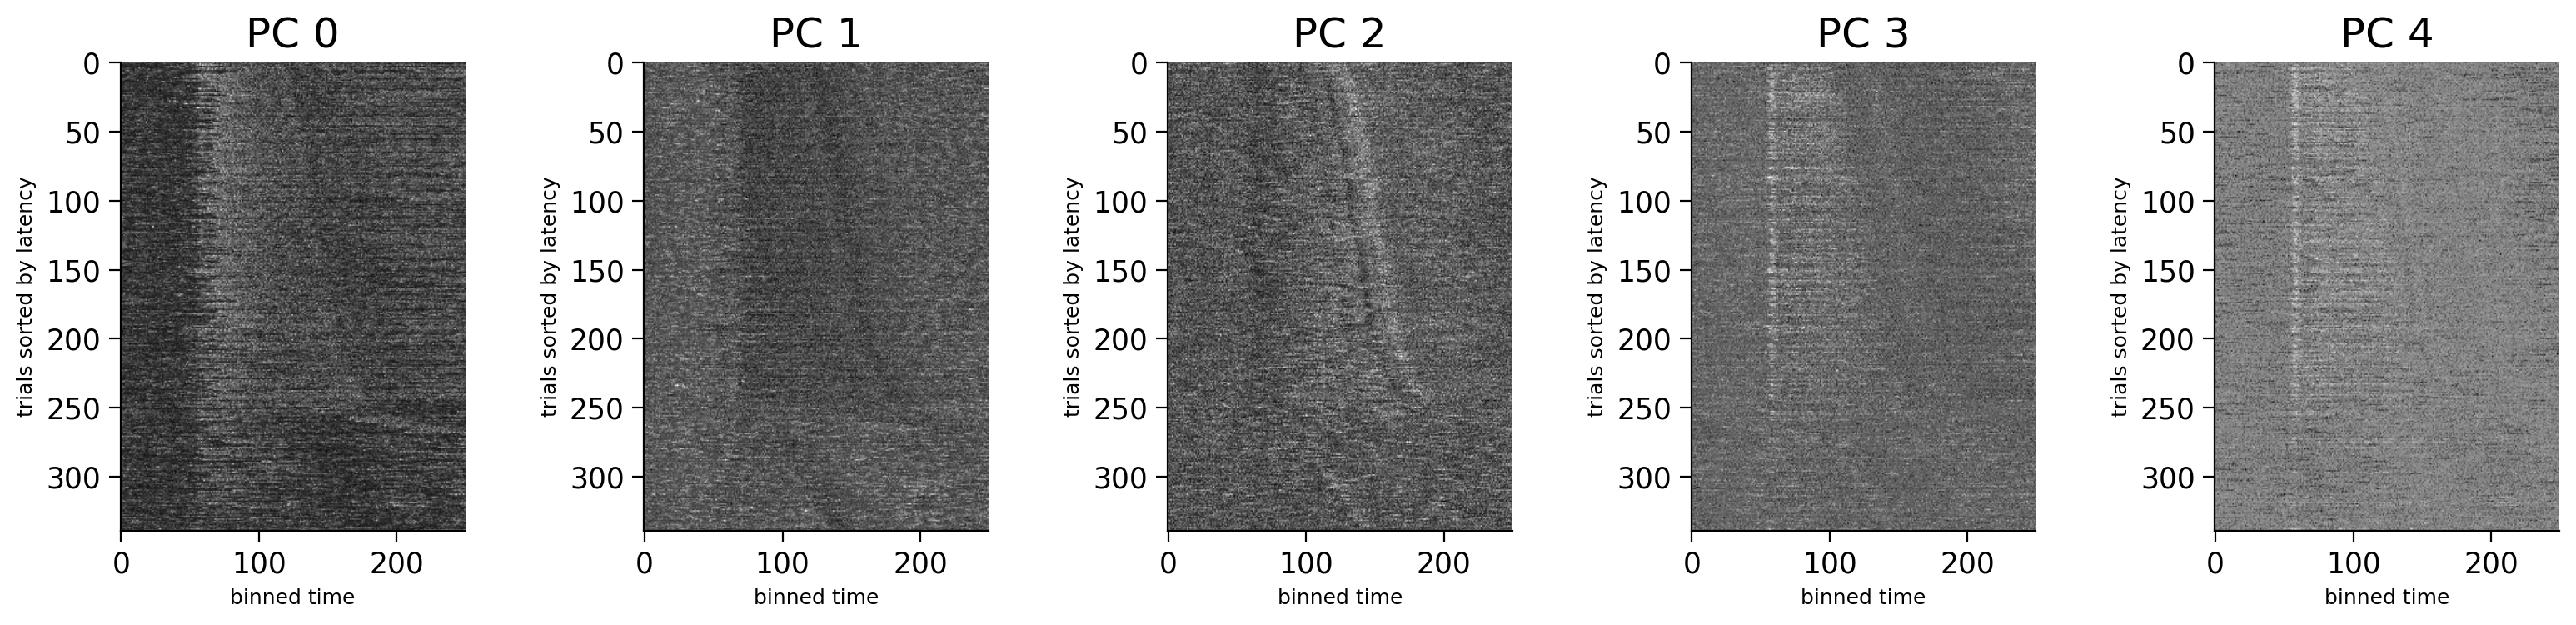

In [ ]:
isort = np.argsort(dat['response_time'].flatten())

plt.figure(figsize = (16,4))

for i in range(pc.shape[0]):
  plt.subplot(151 + i)
  plt.imshow(pc[i,isort,:], cmap=plt.cm.gray)
  plt.xlabel("binned time", fontsize=9)
  plt.ylabel("trials sorted by latency", fontsize=9)
  plt.title(f"PC {i}")

Please generate figures like below and discuss your result in your report. what does each PC shows?
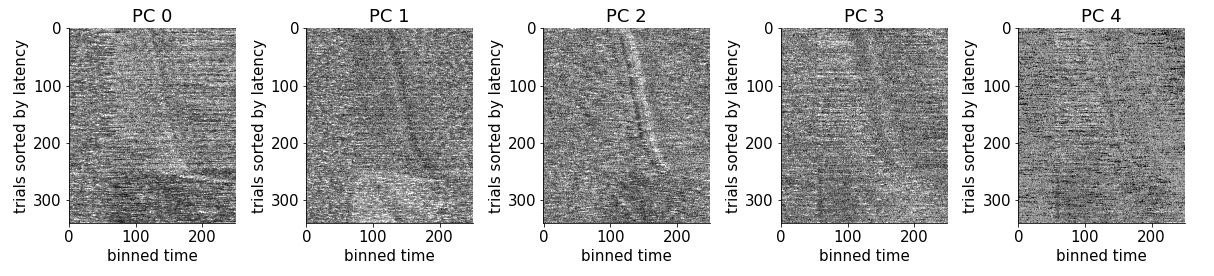

## Bonus (Extra):  *`+15 points`*
use machine learning techniques such as SVM, kmeans or etc. to train a classifier which decodes the rat response in two conditions (LEFT or RIGHT). what would be your accuracy? what is your selected features? which region can classify the LEFT/RIGHT response?

In [ ]:
# Define response types
left_response = dat['response'] == -1
right_response = dat['response'] == 1

# Define features
features = dat['spks']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, right_response, test_size=0.2, random_state=42)

# Train SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict test set labels
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

ValueError: ignored

you can use feature selection techniques such as principal component analysis (PCA) or selectKBest. Here's an example code snippet that uses PCA to select the top 100 principal components

In [ ]:
# Define response types
left_response = dat['response'] == -1
right_response = dat['response'] == 1

# Define features
features = dat['spks']

# Perform feature selection
selector = SelectPercentile(f_classif, percentile=10)
features_selected = selector.fit_transform(features.reshape(features.shape[0], -1), right_response)

# Get indices of selected features
feature_indices = selector.get_support(indices=True)

# Get brain regions of selected features
selected_regions = dat['brain_area'][feature_indices]

print('Selected regions:', selected_regions)

ValueError: ignored

#** PART II: Theory**

 In these tutorials (exercise), we will explore the fundamental concepts of the Bayesian approach. In this tutorial you will work through an example of Bayesian inference and decision making using a binary hidden state.

This notebook will introduce the fundamental building blocks for Bayesian statistics:

1. How do we combine the possible loss (or gain) for making a decision with our probabilistic knowledge?
2. How do we use probability distributions to represent hidden states?
3. How does marginalization work and how can we use it?
4. How do we combine new information with our prior knowledge?

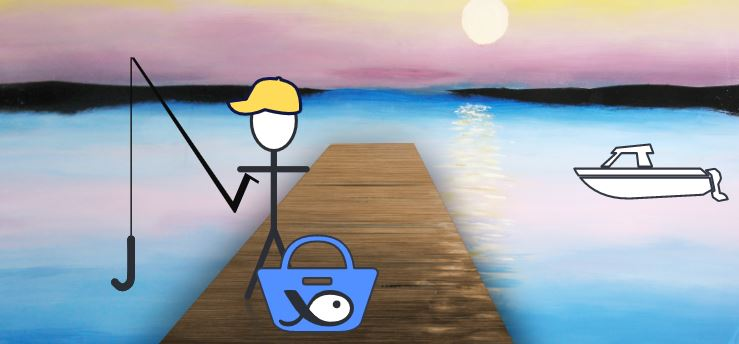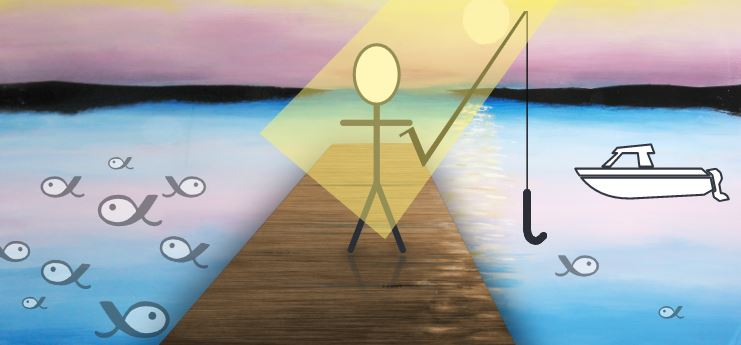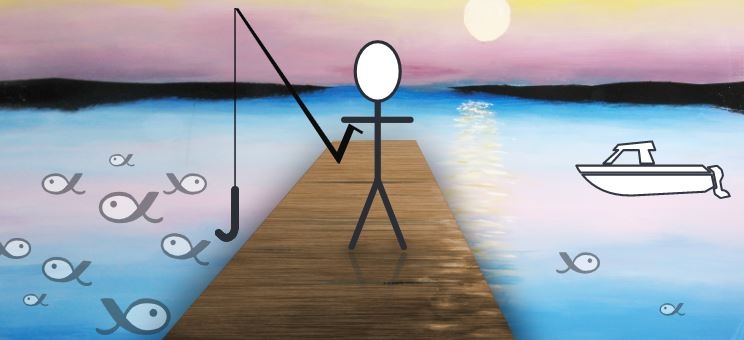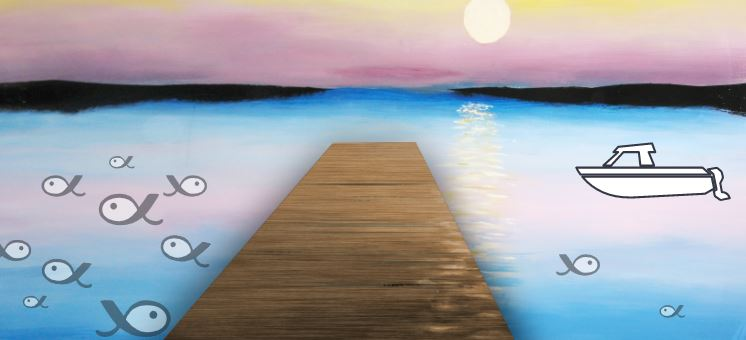

---
# Section 1: Gone Fishin'


In the next two sections we will consider just the probability of where the fish might be and what you gain or lose by choosing where to fish (leaving Bayesian approaches to the last few sections).

Remember, you can either think of yourself as a scientist conducting an experiment or as a brain trying to make a decision. The Bayesian approach is the same!


You need to decide where to fish. It may seem obvious - you could just fish on the side where the probability of the fish being is higher! Unfortunately, decisions and actions are always a little more complicated. Deciding to fish may be influenced by more than just the probability of the school of fish being there as we saw by the potential issues of submarines and sunburn. The consequences of the action you take is based on the true (but hidden) state of the world and the action you choose! In our example, fishing on the wrong side, where there aren't many fish, is likely to lead to you spending your afternoon not catching fish and therefore getting a sunburn. The submarine represents a risk to fishing on the right side that is greater than the left side. If you want to know what to expect from taking the action of fishing on one side or the other, you need to calculate the expected utility.

You know the (prior) probability that the school of fish is on the left side of the dock today, $P(s = \textrm{left})$. So, you also know the probability the school is on the right, $P(s = \textrm{right})$, because these two probabilities must add up to 1.

We quantify gains and losses numerically using a **utility** function $U(s,a)$, which describes the consequences of your actions: how much value you gain (or if negative, lose) given the state of the world ($s$) and the action you take ($a$). In our example, our utility can be summarized as:

| Utility: U(s,a)   | a = left   | a = right  |
| ----------------- |------------|------------|
| s = Left          | +2         | -3         |
| s = right         | -2         | +1         |

To use possible gains and losses to choose an action, we calculate the **expected utility** of that action by weighing these utilities with the probability of that state occuring. This allows us to choose actions by taking probabilities of events into account: we don't care if the outcome of an action-state pair is a loss if the probability of that state is very low. We can formalize this as:

\begin{equation}
\text{Expected utility of action a} = \sum_{s}U(s,a)P(s)
\end{equation}

In other words, the expected utility of an action a is the sum over possible states of the utility of that action and state times the probability of that state.

</details>

---
# Section 2: Deciding where to fish


## Interactive Demo 2: Exploring the decision

Let's start to get a sense of how all this works using the interactive demo below. You can change the probability that the school of fish is on the left side,$p(s = \textrm{left})$, using the slider. You will see the utility function (a matrix) in the middle and the corresponding expected utility for each action on the right.

First, make sure you understand how the expected utility of each action is being computed from the probabilities and the utility values. In the initial state: the probability of the fish being on the left is 0.9 and on the right is 0.1. The expected utility of the action of fishing on the left is then $U(s = \textrm{left},a = \textrm{left})p(s = \textrm{left}) + U(s = \textrm{right},a = \textrm{left})p(s = \textrm{right}) = 2(0.9) + -2(0.1) = 1.6$. Essentially, to get the expected utility of action $a$, you are doing a weighted sum over the relevant column of the utility matrix (corresponding to action $a$) where the weights are the state probabilities.

For each of these scenarios, think and discuss first. Then use the demo to try out each and see if your action would have been correct (that is, if the expected value of that action is the highest).
Answer question below using the included widget.


1.  You just arrived at the dock for the first time and have no sense of where the fish might be. So you guess that the probability of the school being on the left side is 0.5 (so the probability on the right side is also 0.5). Which side would you choose to fish on given our utility values?
2.  You think that the probability of the school being on the left side is very low (0.1) and correspondingly high on the right side (0.9). Which side would you choose to fish on given our utility values?
3.  What would you choose if the probability of the school being on the left side is slightly lower than on the right side (0. 4 vs 0.6)?

*`+15 points`*

In [ ]:
# @markdown Execute this cell to use the widget
ps_widget = widgets.FloatSlider(0.9, description='p(s = left)', min=0.0, max=1.0, step=0.01)

@widgets.interact(
    ps = ps_widget,
)
def make_utility_plot(ps):
    fig = plot_utility(ps)
    plt.show(fig)
    plt.close(fig)
    return None

interactive(children=(FloatSlider(value=0.9, description='p(s = left)', max=1.0, step=0.01), Output()), _dom_c…

In this section, you have seen that both the utility of various state and action pairs and our knowledge of the probability of each state affects your decision. Importantly, we want our knowledge of the probability of each state to be as accurate as possible!

So how do we know these probabilities? We may have prior knowledge from years of fishing at the same dock, learning that the fish are more likely to be on the left side, for example. Of course, we need to update our knowledge (our belief)! To do this, we need to collect more information, or take some measurements! In the next few sections, we will focus on how we improve our knowledge of the probabilities.

---
# Section 3: Likelihood of the fish being on either side

First, we'll think about what it means to take a measurement (also often called an observation or just data) and what it tells you about what the hidden state may be. Specifically, we'll be looking at the likelihood, which is the probability of your measurement ( m ) given the hidden state ( s ):  P(m|s) . Remember that in this case, the hidden state is which side of the dock the school of fish is on. We will watch someone fish (for let's say 10 minutes) and our measurement is whether they catch a fish or not. We know something about what catching a fish means for the likelihood of the fish being on one side or the other.



## Think! 3: Guessing the location of the fish

Let's say we go to a different dock to fish. Here, there are different probabilities of catching fish given the state of the world. At this dock, if you fish on the side of the dock where the fish are, you have a 70% chance of catching a fish. If you fish on the wrong side, you will catch a fish with only 20% probability. These are the likelihoods of observing someone catching a fish! That is, you are taking a measurement by seeing if someone else catches a fish!

You see a fisher-person is fishing on the left side.

1) Please figure out each of the following (might be easiest to do this separately and then compare notes):
- probability of catching a fish given that the school of fish is on the left side, $P(m = \textrm{catch fish} | s = \textrm{left} )$
- probability of not catching a fish given that the school of fish is on the left side, $P(m = \textrm{no fish} | s = \textrm{left})$
- probability of catching a fish given that the school of fish is on the right side, $P(m = \textrm{catch  fish} | s = \textrm{right})$
- probability of not catching a fish given that the school of fish is on the right side, $P(m = \textrm{no fish} | s = \textrm{right})$

2) If the fisher-person catches a fish, which side would you guess the school is on? Why?

3) If the fisher-person does not catch a fish, which side would you guess the school is on? Why?

*`+15 points`*


In the prior exercise, you tried to guess where the school of fish was based on the measurement you took (watching someone fish). You did this by choosing the state (side where you think the fish are) that maximized the probability of the measurement. In other words, you estimated the state by maximizing the likelihood (the side with the highest probability of measurement given state $P(m|s$)). This is called maximum likelihood estimation (MLE).

But, what if you had been going to this dock for years and you knew that the fish were almost always on the left side? This should probably affect how you make your estimate -- you would rely less on the single new measurement and more on your prior knowledge. This is the fundamental idea behind Bayesian inference, as we will see later in this tutorial!

---
# Section 4: Correlation and marginalization


## Section 4.1: Correlation

In this section, we are going to take a step back for a bit and think more generally about the amount of information shared between two random variables. We want to know how much information you gain when you observe one variable (take a measurement) if you know something about another. We will see that the fundamental concept is the same if we think about two attributes, for example the size and color of the fish, or the prior information and the likelihood.


### Think! 4.1: Covarying probability distributions

The relationship between the marginal probabilities and the joint probabilities is determined by the correlation between the two random variables - a normalized measure of how much the variables covary. We can also think of this as gaining some information about one of the variables when we observe a measurement from the other.
Here, we want to think about how the correlation between size and color of these fish changes how much information we gain about one attribute based on the other. See Bonus Section 1 for the formula for correlation.

Use the widget below and answer the following questions:

1. When the correlation is zero, $\rho = 0$, what does the distribution of size tell you about color?
2. Set $\rho$ to something small. As you change the probability of golden fish, what happens to the ratio of size probabilities? Set $\rho$ larger (can be negative). Can you explain the pattern of changes in the probabilities of size as you change the probability of golden fish?
3. Set the probability of golden fish and of large fish to around 65%. As the correlation goes towards 1, how often will you see silver large fish?
4. What is increasing the (absolute) correlation telling you about how likely you are to see one of the properties if you see a fish with the other?

*`+12 points`*

In [ ]:
# @markdown Execute this cell to enable the widget
style = {'description_width': 'initial'}
gs = GridspecLayout(2,2)

cor_widget = widgets.FloatSlider(0.0, description='ρ', min=-1, max=1, step=0.01)
px_widget = widgets.FloatSlider(0.5, description='p(color=golden)', min=0.01, max=0.99, step=0.01, style=style)
py_widget = widgets.FloatSlider(0.5, description='p(size=large)', min=0.01, max=0.99, step=0.01, style=style)
gs[0,0] = cor_widget
gs[0,1] = px_widget
gs[1,0] = py_widget


@widgets.interact(
    px=px_widget,
    py=py_widget,
    cor=cor_widget,
)
def make_corr_plot(px, py, cor):
    Cmin, Cmax = compute_cor_range(px, py) #allow correlation values
    cor_widget.min, cor_widget.max = Cmin+0.01, Cmax-0.01
    if cor_widget.value > Cmax:
        cor_widget.value = Cmax
    if cor_widget.value < Cmin:
        cor_widget.value = Cmin
    cor = cor_widget.value
    P = compute_marginal(px,py,cor)
    # print(P)
    fig = plot_joint_probs(P)
    plt.show(fig)
    plt.close(fig)
    return None

# gs[1,1] = make_corr_plot()

interactive(children=(FloatSlider(value=0.5, description='p(color=golden)', layout=Layout(grid_area='widget002…

We have just seen how two random variables can be more or less independent. The more correlated, the less independent, and the more shared information. We also learned that we can marginalize to determine the marginal likelihood of a measurement or to find the marginal probability distribution of two random variables. We are going to now complete our journey towards being fully Bayesian!

## Section 4.2: Marginalisation


We may want to find the probability of one variable while ignoring another: we will do this by averaging out, or marginalizing, the irrelevant variable.

We will think of this in two different ways.

In the first math exercise, you will think about the case where you know the joint probabilities of two variables and want to figure out the probability of just one variable. To make this explicit, let's assume that a fish has a color that is either gold or silver (our first variable) and a size that is either small or large (our second). We could write out the the **joint probabilities**: the probability of both specific attributes occuring together. For example, the probability of a fish being small and silver, $P(X = \textrm{small}, Y = \textrm{silver})$, is 0.4. The following table summarizes our joint probabilities:

| P(X, Y)        | Y = silver  | Y = gold  |
| -------------- |-------------|-----------|
| X = small      | 0.4         | 0.2       |
| X = large      | 0.1         | 0.3       |


We want to know what the probability of a fish being small  regardless of color. Since the fish are either silver or gold, this would be the probability of a fish being small and silver plus the probability of a fish being small and gold. This is an example of marginalizing, or averaging out, the variable we are not interested in across the rows or columns.. In math speak: $P(X = \textrm{small}) = \sum_y{P(X = \textrm{small}, Y)}$. This gives us a **marginal probability**, a probability of a variable outcome (in this case size), regardless of the other variables (in this case color).

More generally, we can marginalize out a second irrelevant variable $y$ by summing over the relevant joint probabilities:

$$p(x) = \sum_y p(x, y) $$


In the second math exercise, you will remove an unknown (the hidden state) to find the marginal probability of a measurement. You will do this by marginalizing out the hidden state. In this case, you know the conditional probabilities of the measurement given state and the probabilities of each state. You can marginalize using:

$$p(m) = \sum_s p(m | s) p(s) $$

These two ways of thinking about marginalization (as averaging over joint probabilities or conditioning on some variable) are equivalent because the joint probability of two variables equals the conditional probability of the first given the second times the marginal probability of the second:

$$p(x, y) = p(x|y)p(y)$$



### Math Exercise 4.2.1: Computing marginal probabilities

To understand the information between two variables, let's first consider the joint probabilities over the size and color of the fish.

| P(X, Y)        | Y = silver  | Y = gold  |
| -------------- |-------------|-----------|
| X = small      | 0.4         | 0.2       |
| X = large      | 0.1         | 0.3       |

Please complete the following math problems to further practice thinking through probabilities:

1. Calculate the probability of a fish being silver.
2. Calculate the probability of a fish being small, large, silver, or gold.
3. Calculate the probability of a fish being small OR gold. **Hint:** $P(A\ \textrm{or}\ B) = P(A) + P(B) - P(A\ \textrm{and}\ B)$.

*`+15 points`*

In [ ]:
"""
Joint probabilities

P( X = small, Y = silver) = 0.4
P( X = large, Y = silver) = 0.1
P( X = small, Y = gold) = 0.2
P( X = large, Y = gold) = 0.3


1. P(Y = silver) = ...

2. P(X = small or large, Y = silver or gold) = ...

3. P( X = small or Y = gold) = ...

"""

### Math Exercise 4.2.2: Computing marginal likelihood

When we normalize to find the posterior, we need to determine the marginal likelihood--or evidence--for the measurement we observed. To do this, we need to marginalize as we just did above to find the probabilities of a color or size. Only, in this case, we are marginalizing to remove a conditioning variable! In this case, let's consider the likelihood of fish (if we observed a fisher-person fishing on the **right**).

| p(m\|s)       | m = fish | m = no fish  |
| ------------ | ---------- | -------------- |
| s = left     | 0.1      | 0.9          |
| s = right    | 0.5      | 0.5          |


The table above shows us the **likelihoods**, just as we explored earlier.

You want to know the total probability of a fish being caught, $P(m = \textrm{fish})$, by the fisher-person fishing on the right. (You would need this to calculate the posterior.) To do this, you will need to consider the prior probability, $p(s)$, and marginalize over the hidden states!

This is an example of marginalizing, or conditioning away, the variable we are not interested in as well.

Please complete the following math problems to further practice thinking through probabilities:

1. Calculate the marginal likelihood of the fish being caught, $P(m = \textrm{fish})$, if the priors are: $p(s = \textrm{left}) = 0.3$ and $p(s = \textrm{right}) = 0.7$.
2. Calculate the marginal likelihood of the fish being caught,  $P(m = \textrm{fish})$, if the priors are: $p(s = \textrm{left}) = 0.6$ and $p(s = \textrm{right}) = 0.4$.

*`+10 points`*

In [ ]:
"""

Priors
P(s = left) = 0.3
P(s = right) = 0.7

Likelihoods
P(m = fish | s = left) = 0.1
P(m = fish | s = right) = 0.5
P(m = no fish | s = left) = 0.9
P(m = no fish | s = right) = 0.5

1. P(m = fish) = ...

2. P(m = fish) = ...

"""

---
# Section 5: Bayes' Rule and the Posterior


Marginalization is going to be used to combine our prior knowledge, which we call the **prior**, and our new information from a measurement, the **likelihood**. Only in this case, the information we gain about the hidden state we are interested in, where the fish are, is based on the relationship between the probabilities of the measurement and our prior.

We can now calculate the full posterior distribution for the hidden state ($s$) using Bayes' Rule. As we've seen, the posterior is proportional to the prior times the likelihood. This means that the posterior probability of the hidden state ($s$) given a measurement ($m$) is proportional to the likelihood of the measurement given the state times the prior probability of that state:

\begin{equation}
P(s | m) \propto P(m | s) P(s)
\end{equation}

We say proportional to instead of equal because we need to normalize to produce a full probability distribution:

\begin{equation}
P(s | m) = \frac{P(m | s) P(s)}{P(m)}
\end{equation}

Normalizing by this $P(m)$ means that our posterior is a complete probability distribution that sums or integrates to 1 appropriately. We now can use this new, complete probability distribution for any future inference or decisions we like! In fact, as we will see tomorrow, we can use it as a new prior! Finally, we often call this probability distribution our beliefs over the hidden states, to emphasize that it is our subjective knowledge about the hidden state.

For many complicated cases, like those we might be using to model behavioral or brain inferences, the normalization term can be intractable or extremely complex to calculate. We can be careful to choose probability distributions whfere we can analytically calculate the posterior probability or numerical approximation is reliable. Better yet, we sometimes don't need to bother with this normalization! The normalization term, $P(m)$, is the probability of the measurement. This does not depend on state so is essentially a constant we can often ignore. We can compare the unnormalized posterior distribution values for different states because how they relate to each other is unchanged when divided by the same constant. We will see how to do this to compare evidence for different hypotheses tomorrow. (It's also used to compare the likelihood of models fit using maximum likelihood estimation)

In this relatively simple example, we can compute the marginal likelihood $P(m)$ easily by using:

\begin{equation}
P(m) = \sum_s P(m | s) P(s)
\end{equation}

We can then normalize so that we deal with the full posterior distribution.

## Math Exercise 5: Calculating a posterior probability

Our prior is $p(s = \textrm{left}) = 0.3$ and $p(s = \textrm{right}) = 0.7$.we learned that the chance of catching a fish given they fish on the same side as the school was 50%. Otherwise, it was 10%. We observe a person fishing on the left side. Our likelihood is:


| Likelihood: p(m \| s) | m = fish   | m = no fish  |
| ----------------- |----------|----------|
| s = left          | 0.5          | 0.5         |
| s = right         | 0.1        |  0.9       |


Calculate the posterior probability (on paper) that:

1. The school is on the left if the fisher-person catches a fish: $p(s = \textrm{left} | m = \textrm{fish})$ (hint: normalize by computing $p(m = \textrm{fish})$)
2. The school is on the right if the fisher-person does not catch a fish: $p(s = \textrm{right} | m = \textrm{no fish})$

*`+10 points`*

In [ ]:
"""
Priors
p(s = left) = 0.3
p(s = right) = 0.7

Likelihoods
P(m = fish | s = left) = 0.5
P(m = fish | s = right) = 0.1
P(m = no fish | s = left) = 0.5
P(m = no fish | s = right) = 0.9

1. p( s = left | m = fish) = ...

2. p( s = right | m = no fish ) = ...

"""

## Extra (Bonus): Coding Exercise 5: Computing Posteriors

Let's implement our above math to be able to compute posteriors for different priors and likelihoods.

As before, our prior is $p(s = \textrm{left}) = 0.3$ and $p(s = \textrm{right}) = 0.7$. we learned that the chance of catching a fish given they fish on the same side as the school was 50%. Otherwise, it was 10%. We observe a person fishing on the left side. Our likelihood is:


| Likelihood: p(m \| s) | m = fish   | m = no fish  |
| ----------------- |----------|----------|
| s = left          | 0.5          | 0.5         |
| s = right         | 0.1        |  0.9       |


We want our full posterior to take the same 2 by 2 form. Make sure the outputs match your math answers!

*`+5 points`*


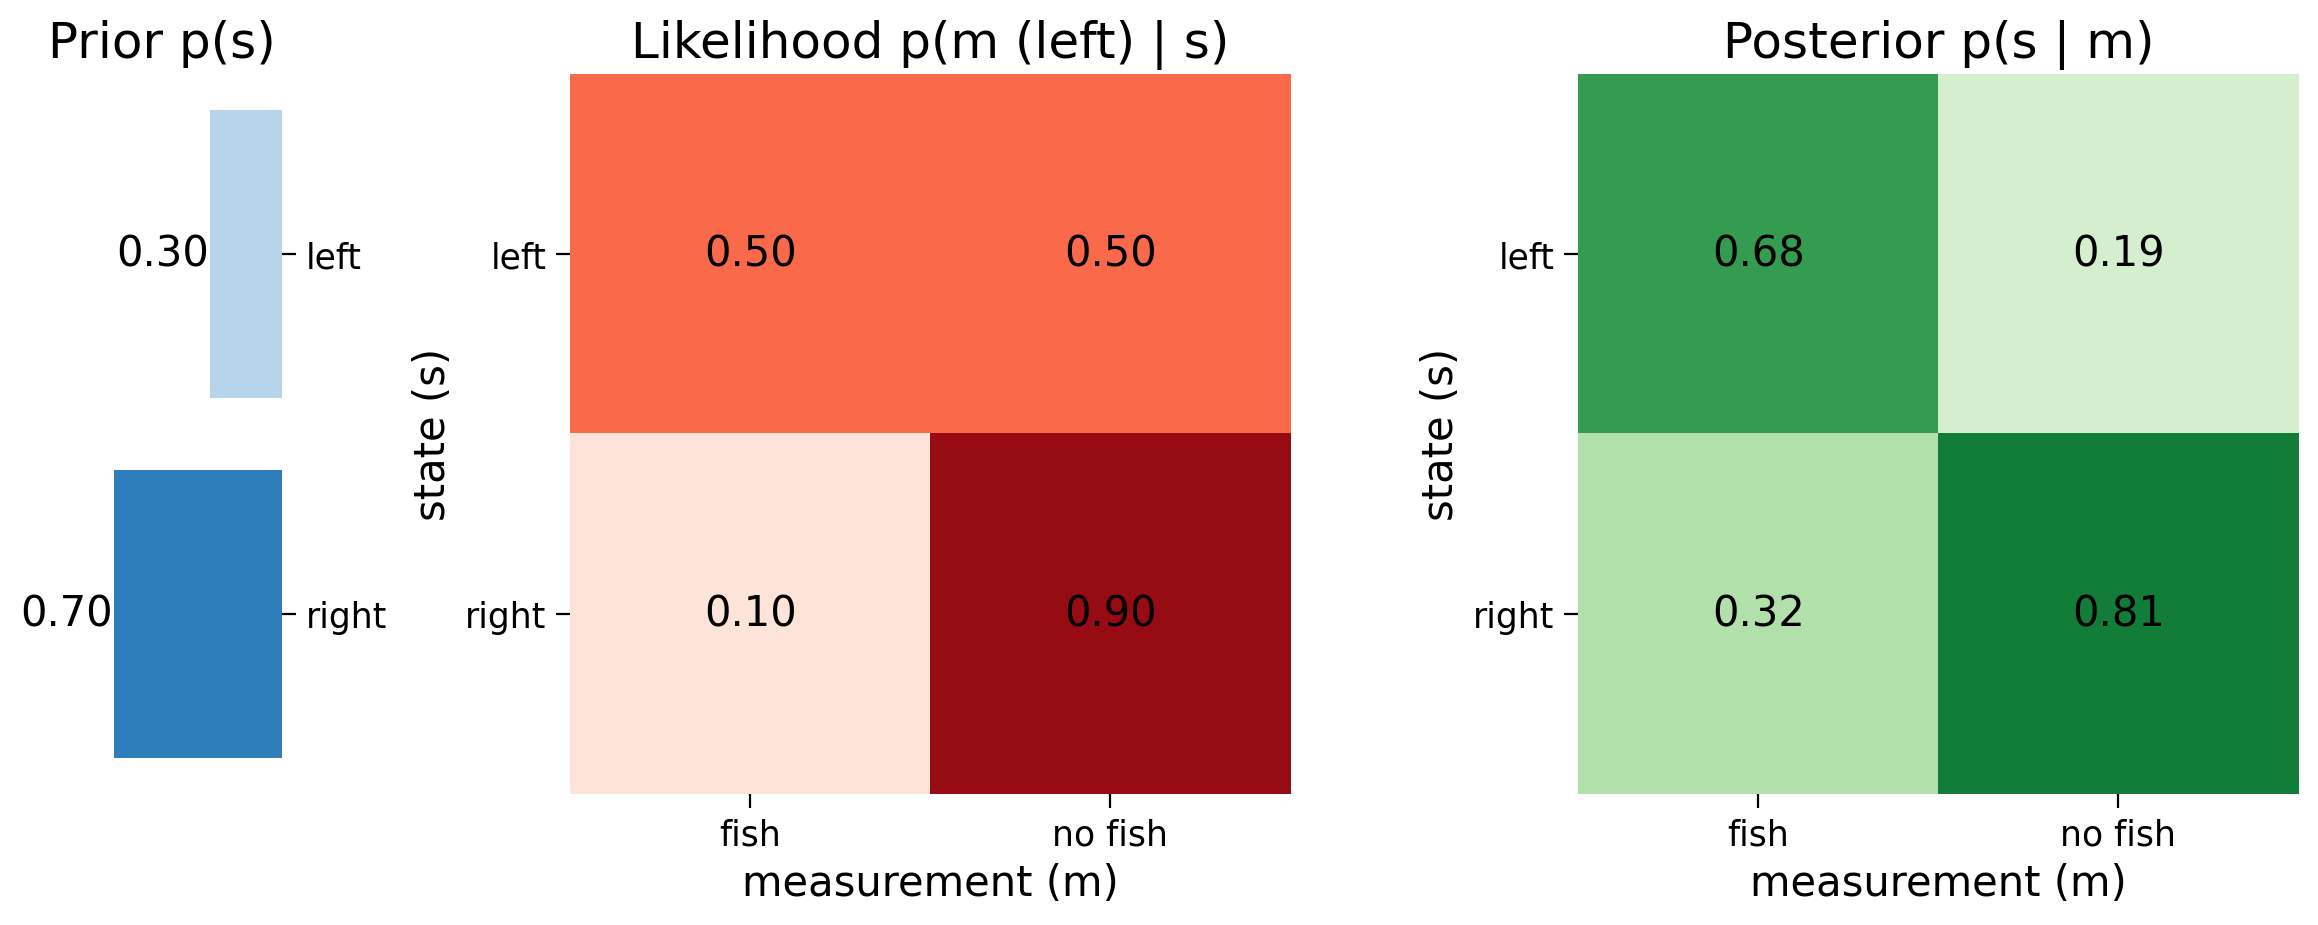

In [ ]:
def compute_posterior(likelihood, prior):
  """ Use Bayes' Rule to compute posterior from likelihood and prior

  Args:
    likelihood (ndarray): i x j array with likelihood probabilities where i is
                    number of state options, j is number of measurement options
    prior (ndarray): i x 1 array with prior probability of each state

  Returns:
    ndarray: i x j array with posterior probabilities where i is
            number of state options, j is number of measurement options

  """

  posterior = likelihood * prior
  p_m = np.sum(posterior, axis = 0)

  # Normalize posterior (divide elements by p_m)
  posterior /= p_m

  return posterior


# Make prior
prior = np.array([0.3, 0.7]).reshape((2, 1)) # first row is s = left, second row is s = right

# Make likelihood
likelihood = np.array([[0.5, 0.5], [0.1, 0.9]]) # first row is s = left, second row is s = right

# Compute posterior
posterior = compute_posterior(likelihood, prior)

# Visualize
plot_prior_likelihood_posterior(prior, likelihood, posterior)

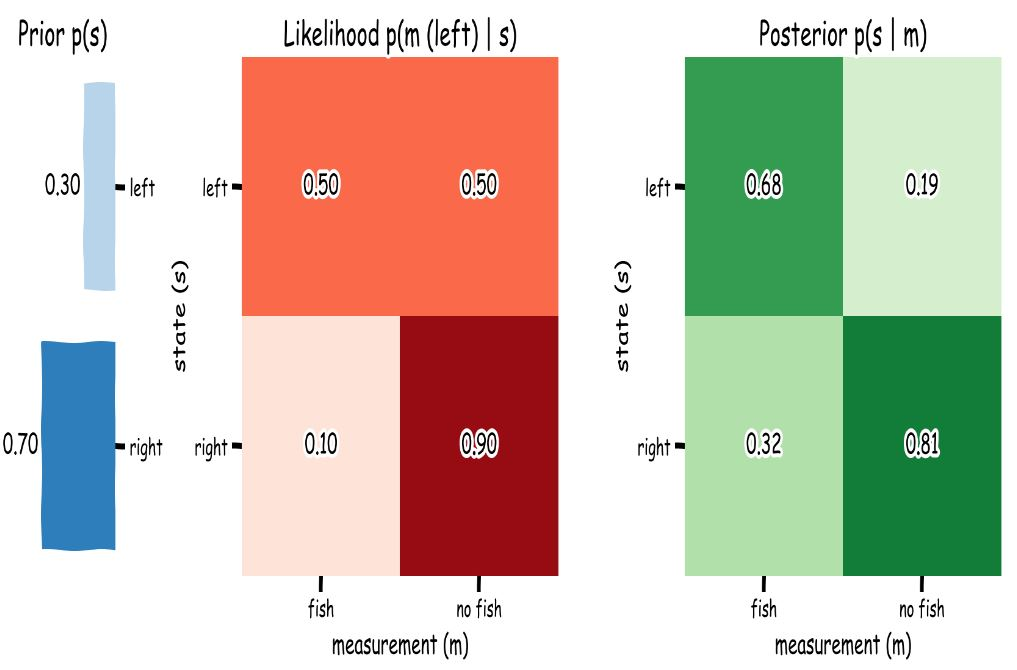

## Extra (Bonus): Interactive Demo 5: What affects the posterior?

Now that we can understand the implementation of *Bayes rule*, let's vary the parameters of the prior and likelihood to see how changing the prior and likelihood affect the posterior.

In the demo below, you can change the prior by playing with the slider for $p( s = left)$. You can also change the likelihood by changing the probability of catching a fish given that the school is on the left and the probability of catching a fish given that the school is on the right. The fisher-person you are observing is fishing on the left.


1.   Keeping the likelihood constant, when does the prior have the strongest influence over the posterior? Meaning, when does the posterior look most like the prior no matter whether a fish was caught or not?
2.   What happens if the likelihoods for catching a fish are similar when you fish on the correct or incorrect side?
3.  Set the prior probability of the state = left to 0.6 and play with the likelihood. When does the likelihood exert the most influence over the posterior?

*`+6 points`*

Output()

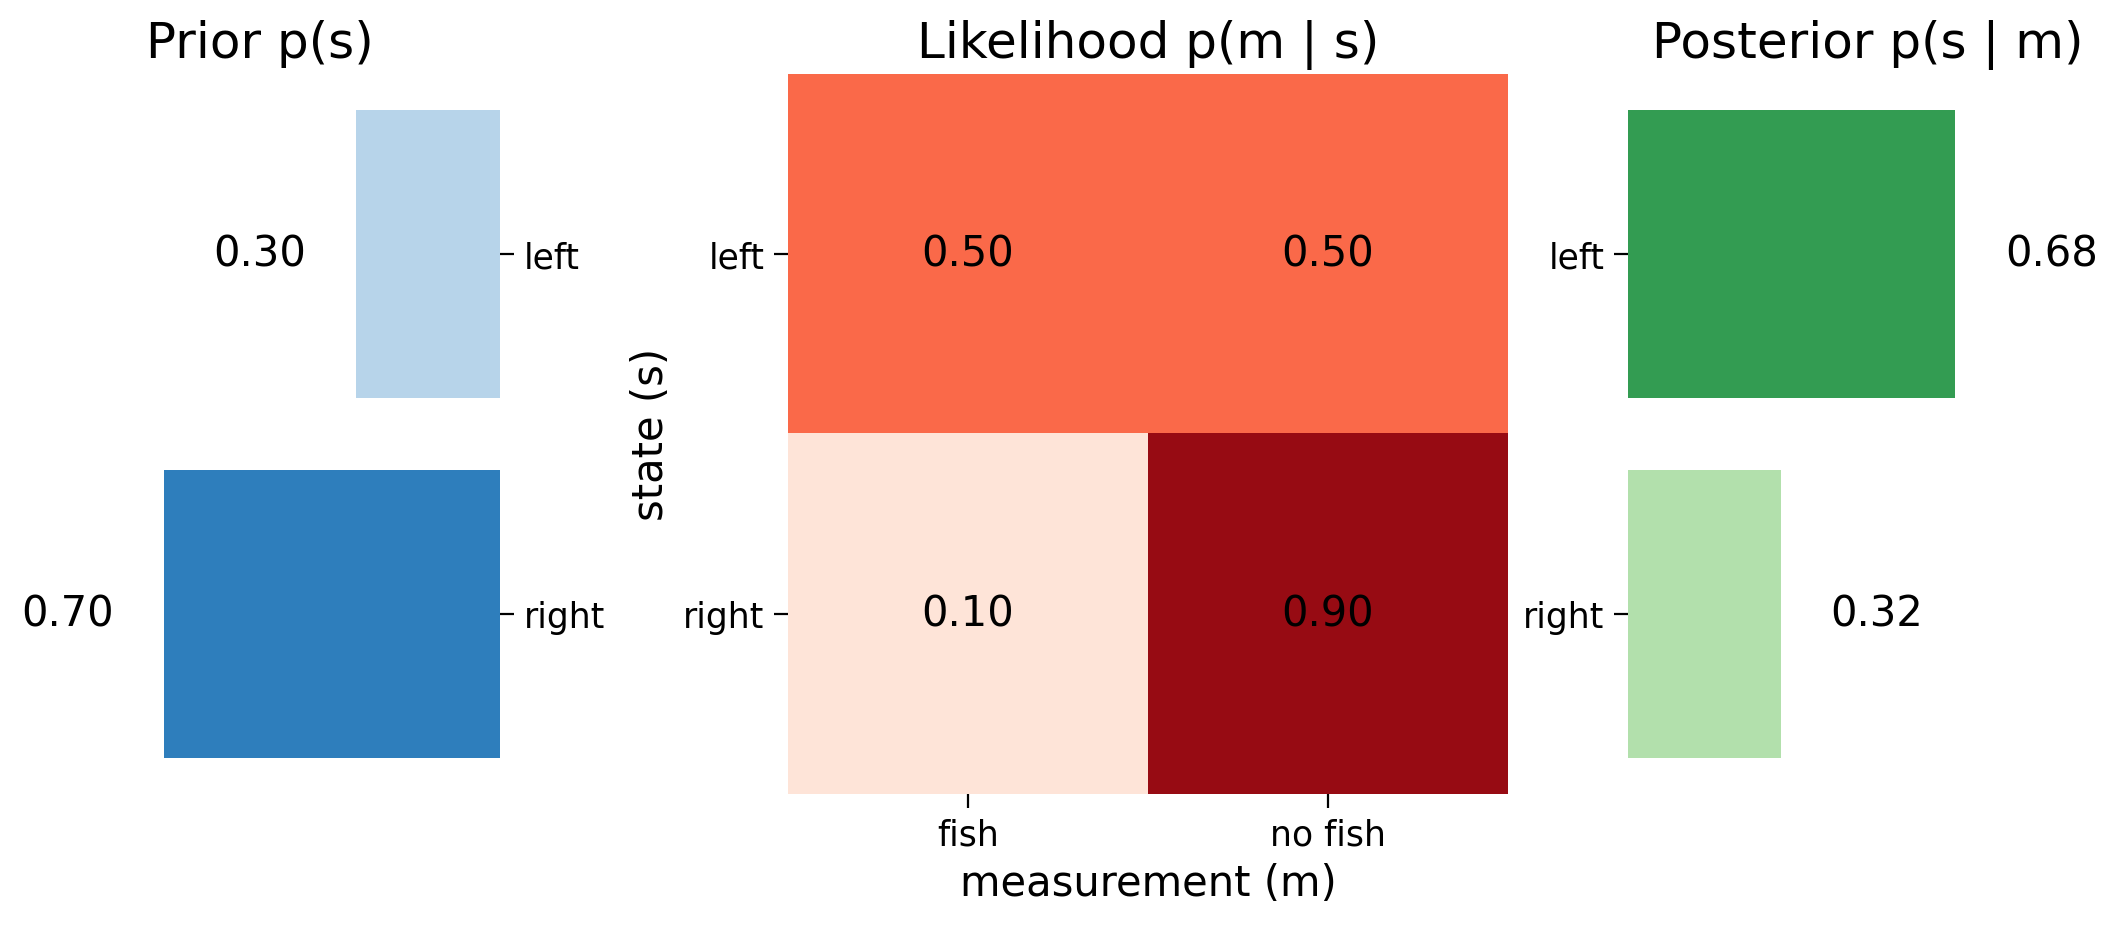

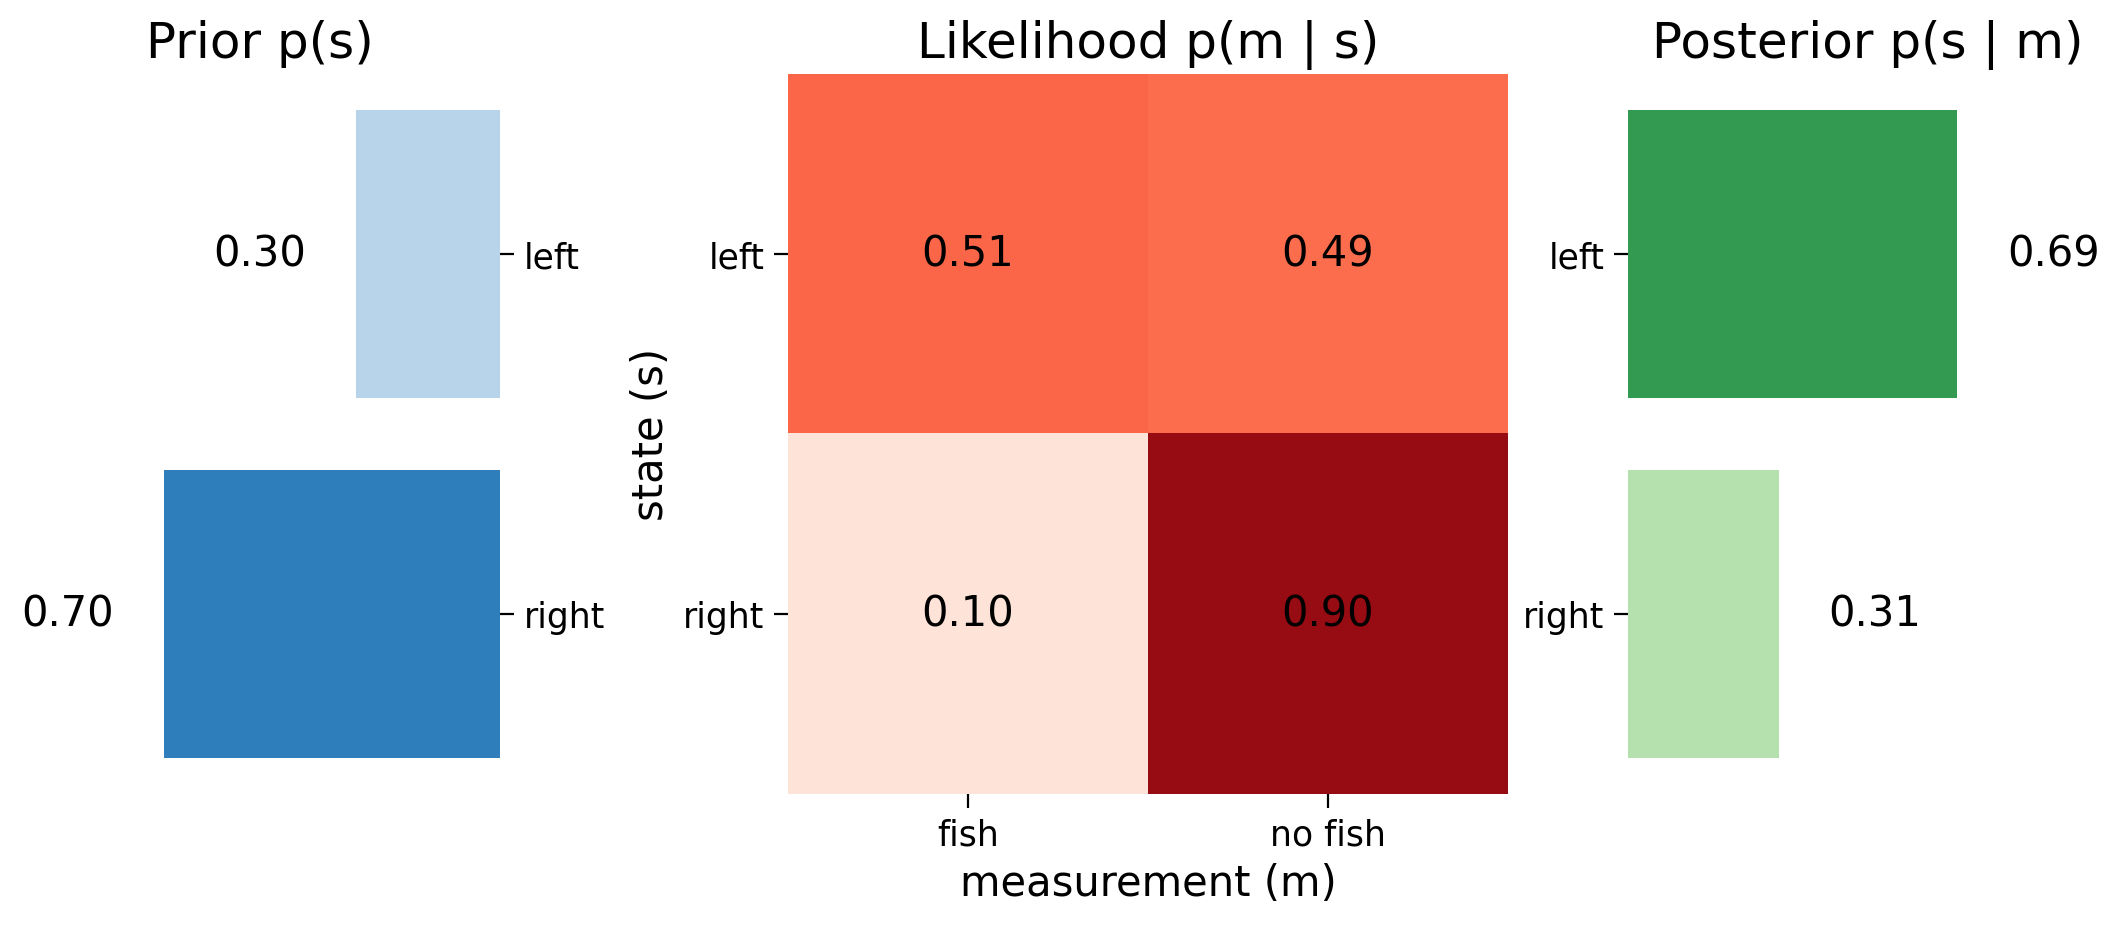

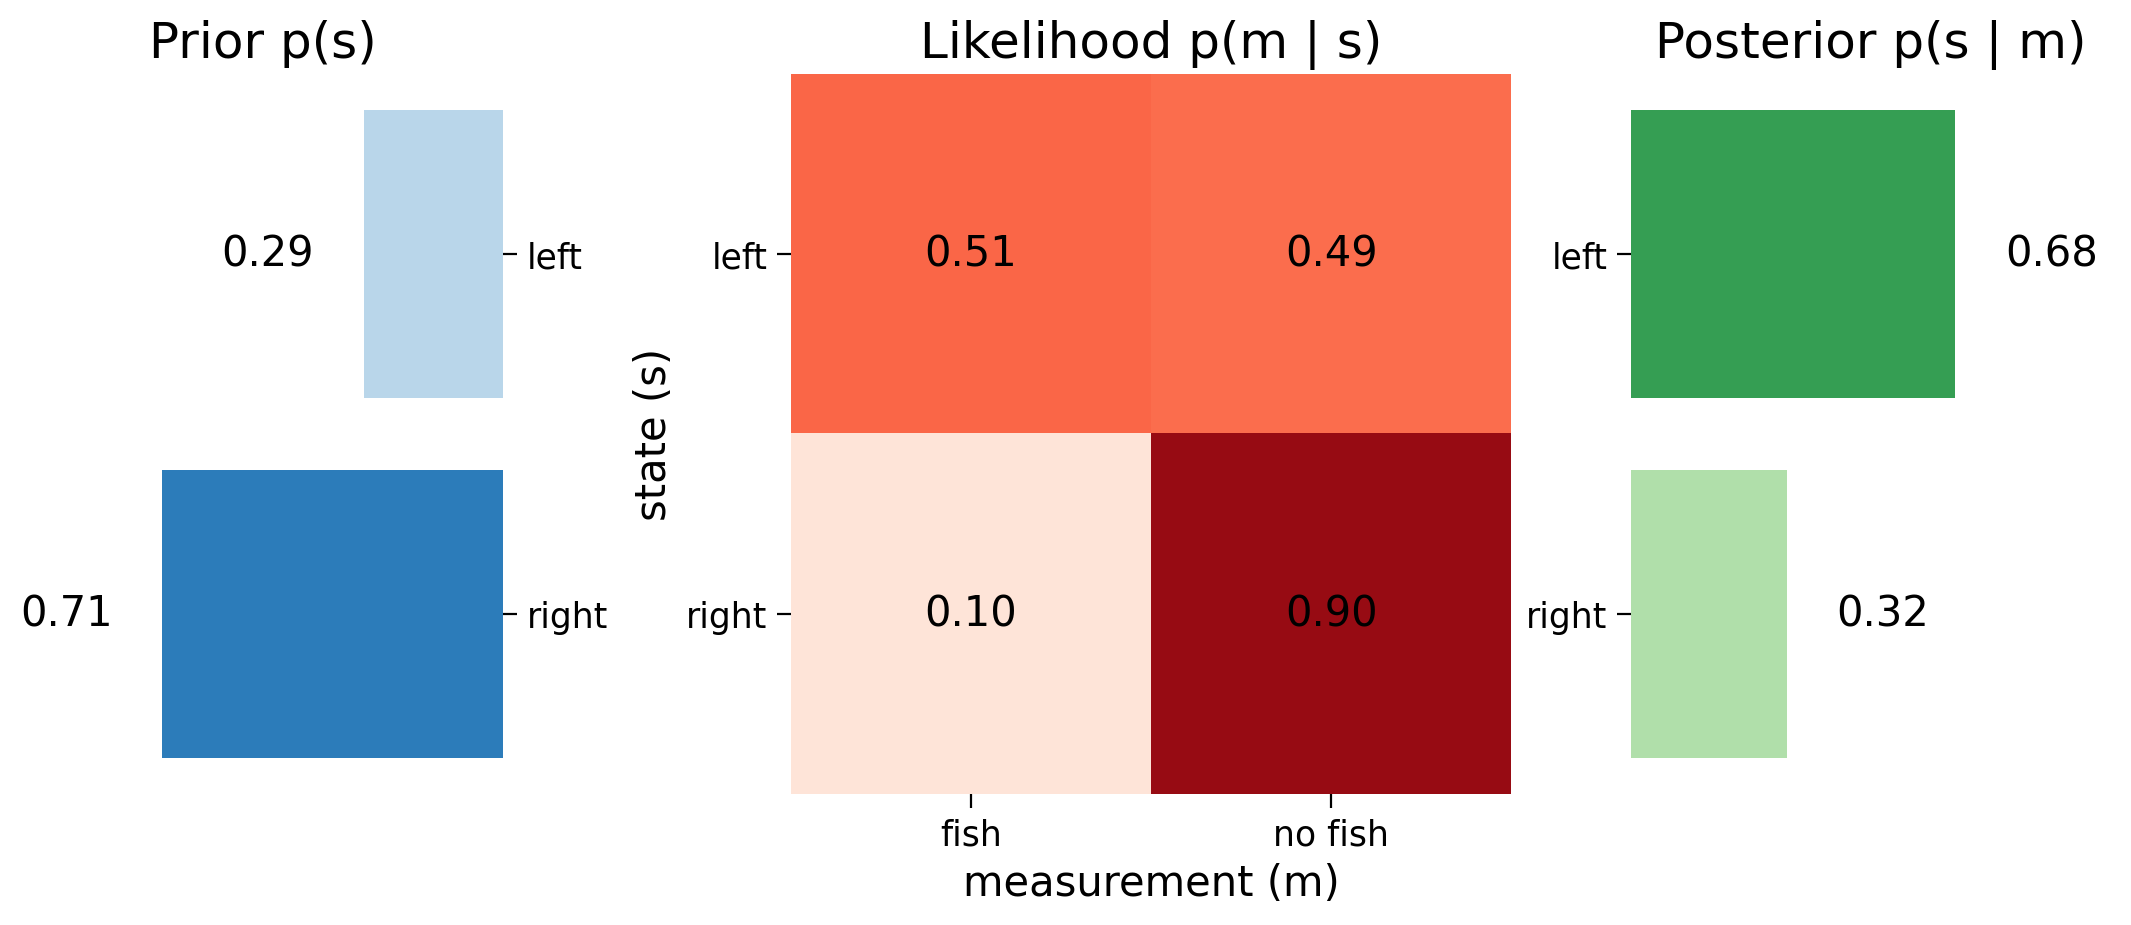

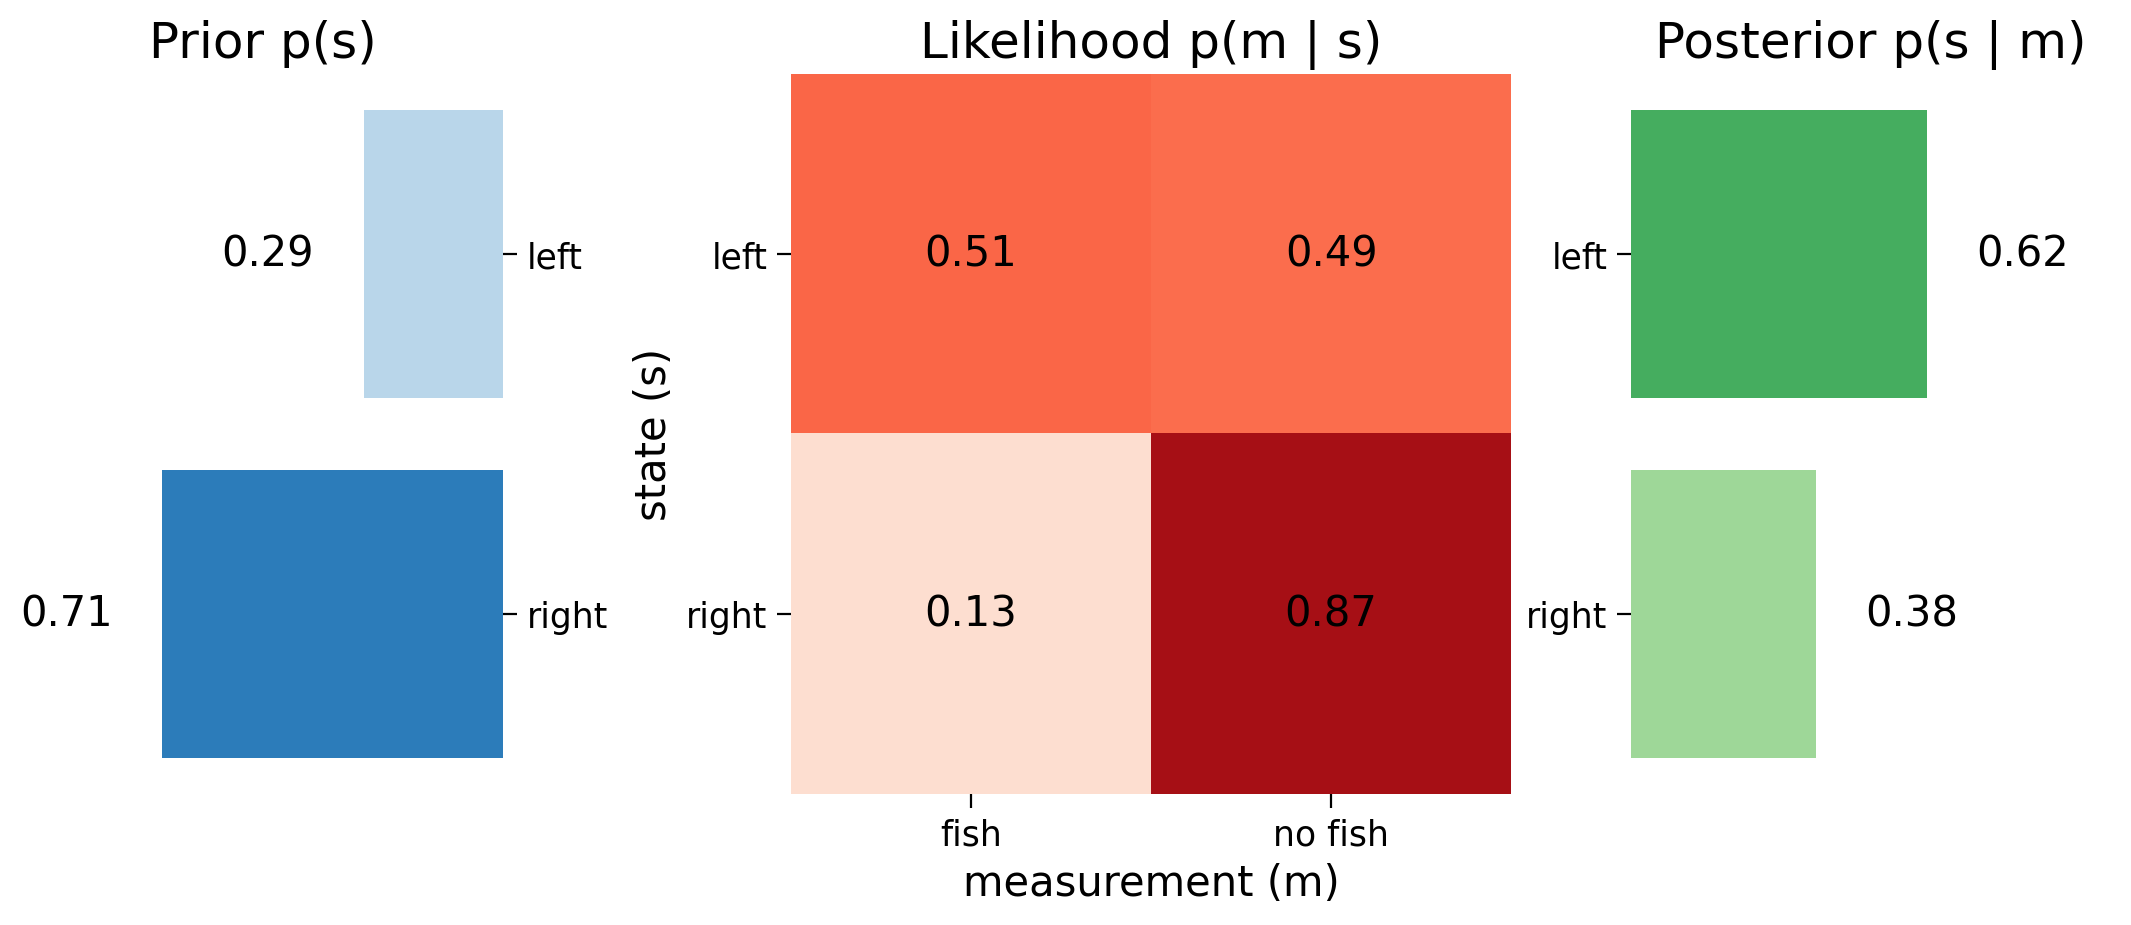

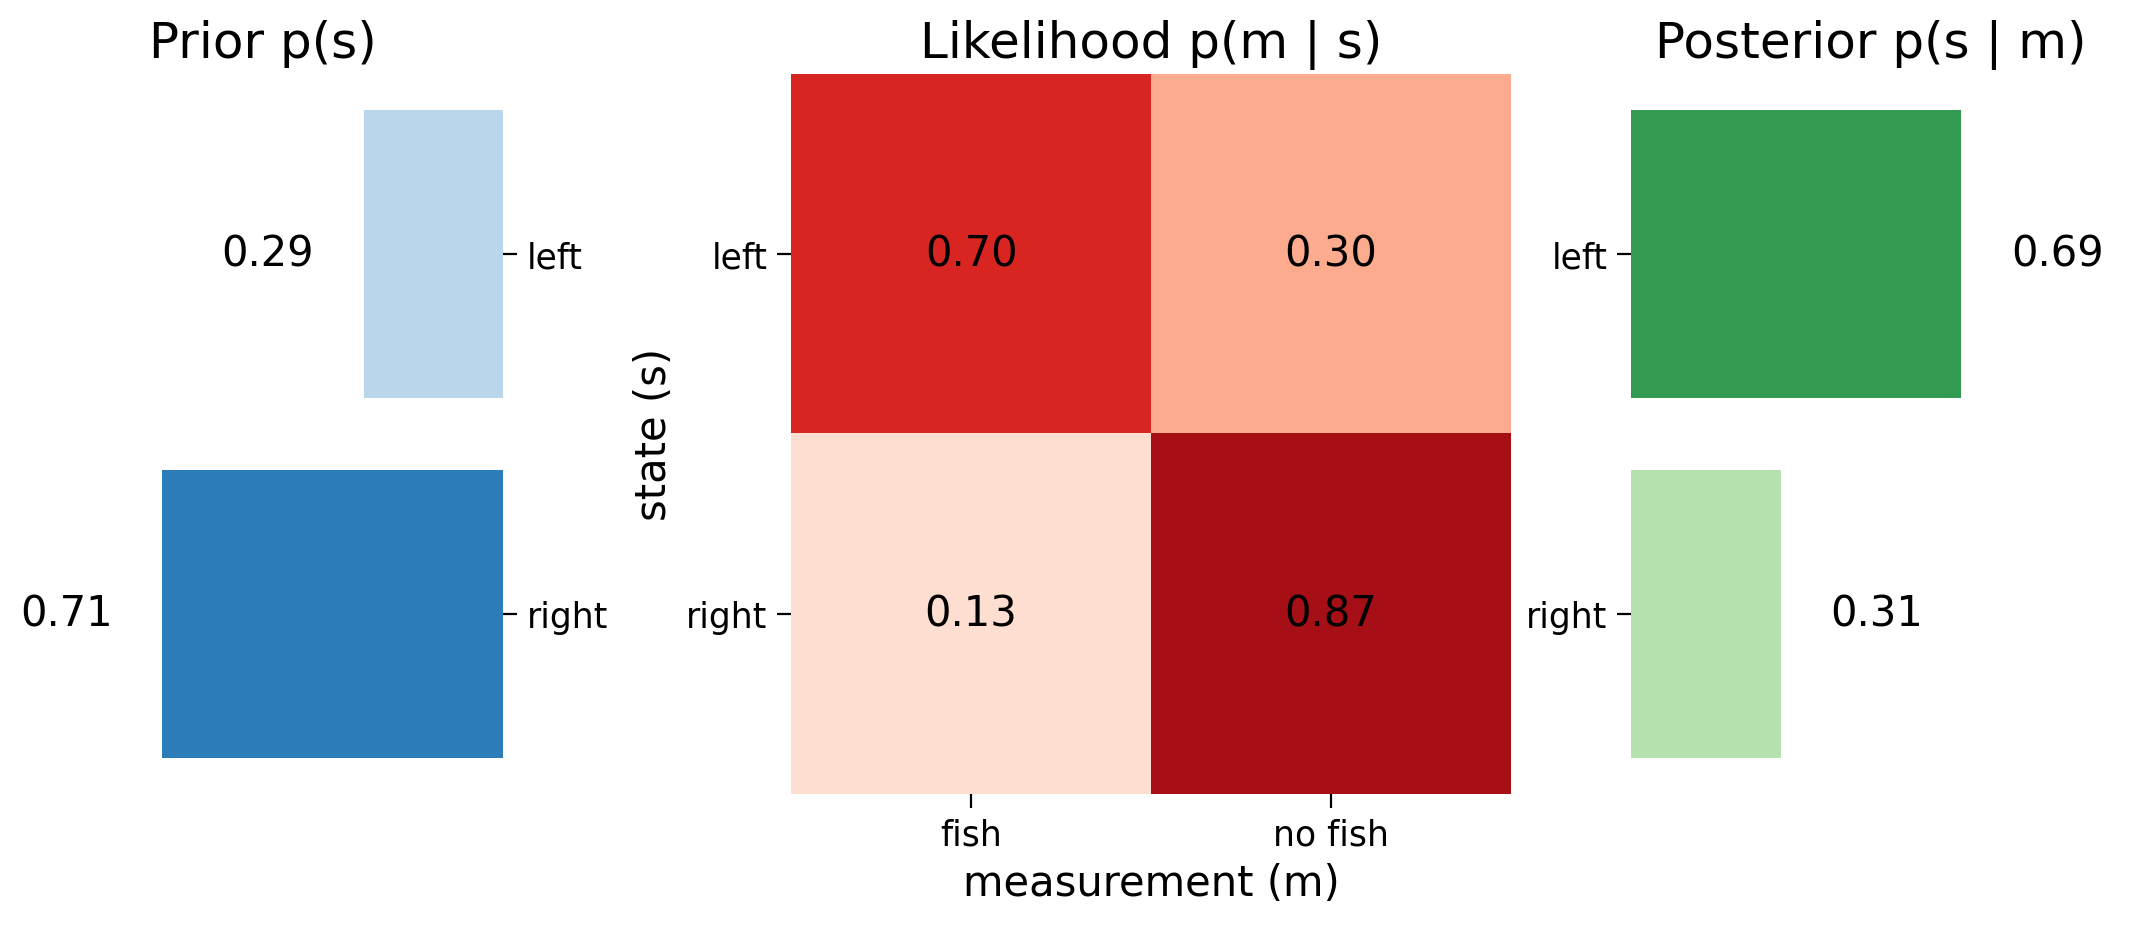

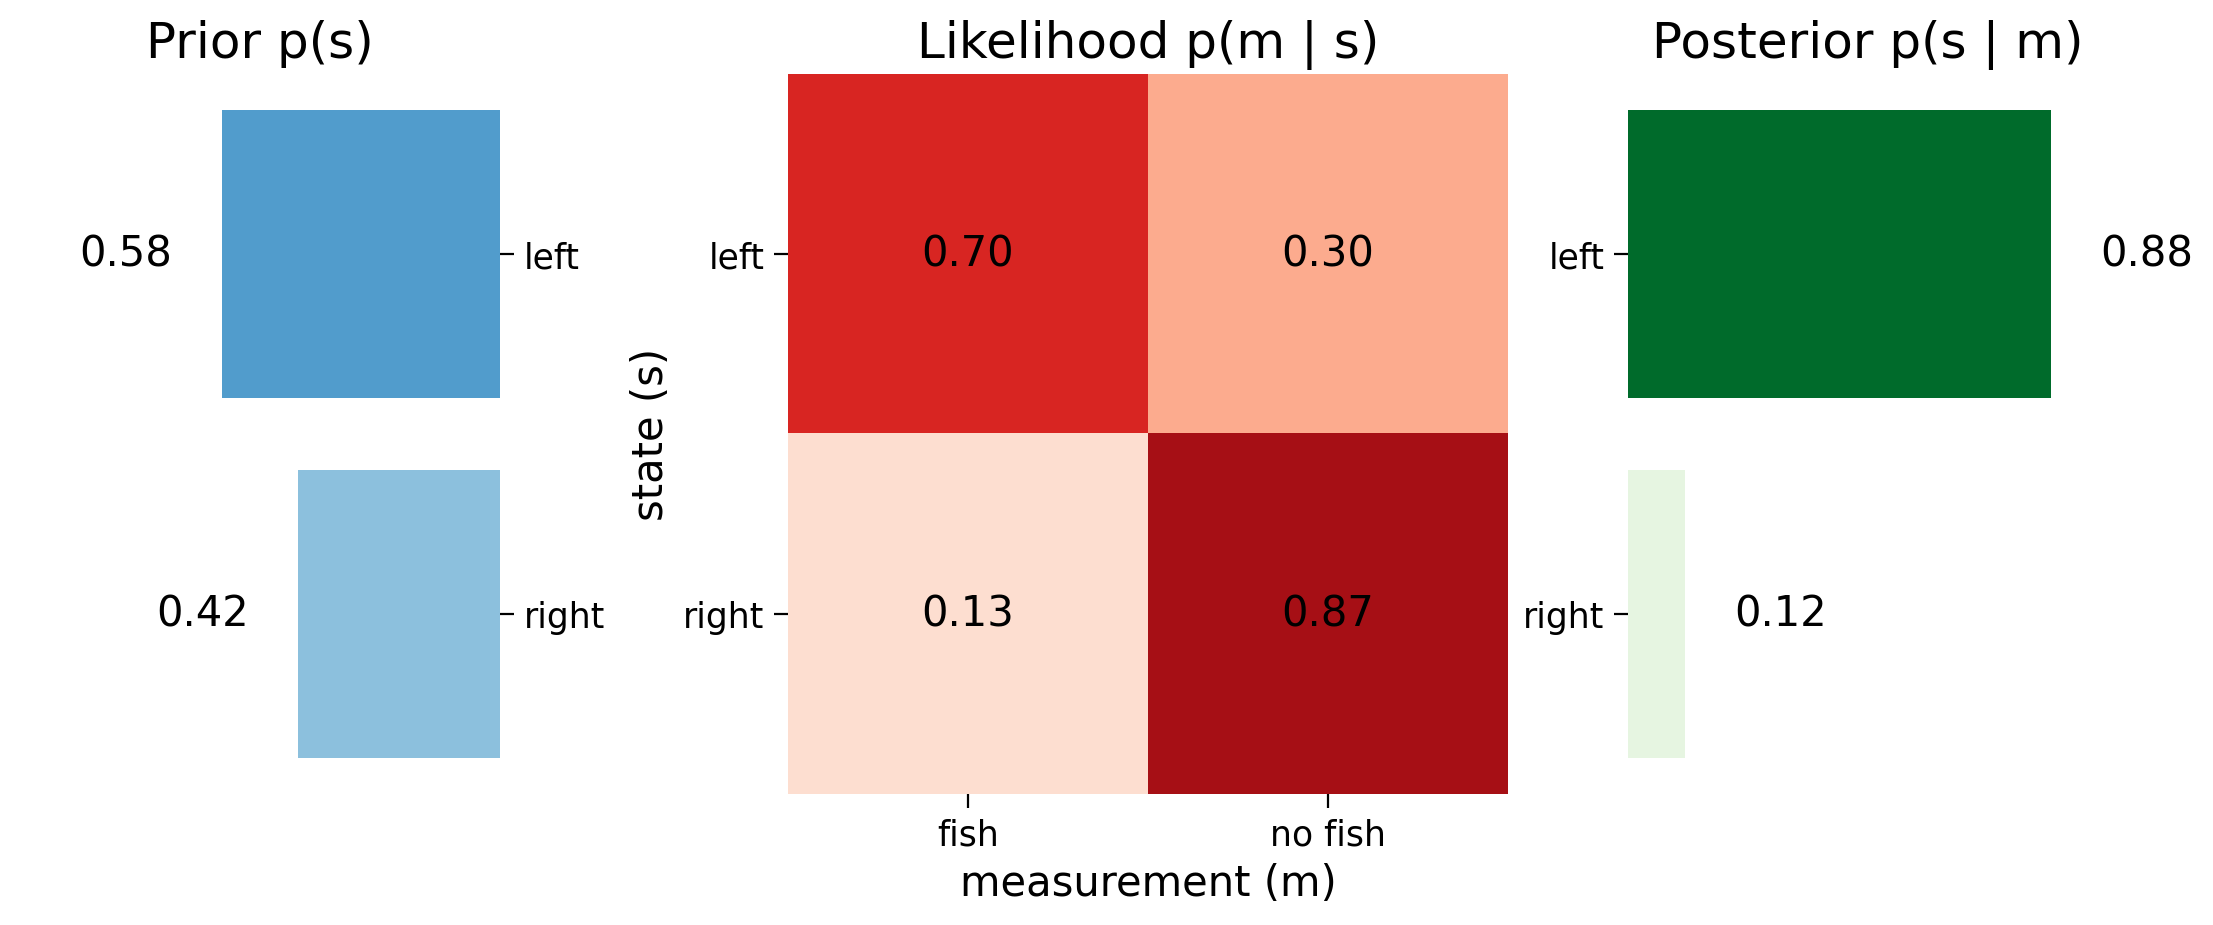

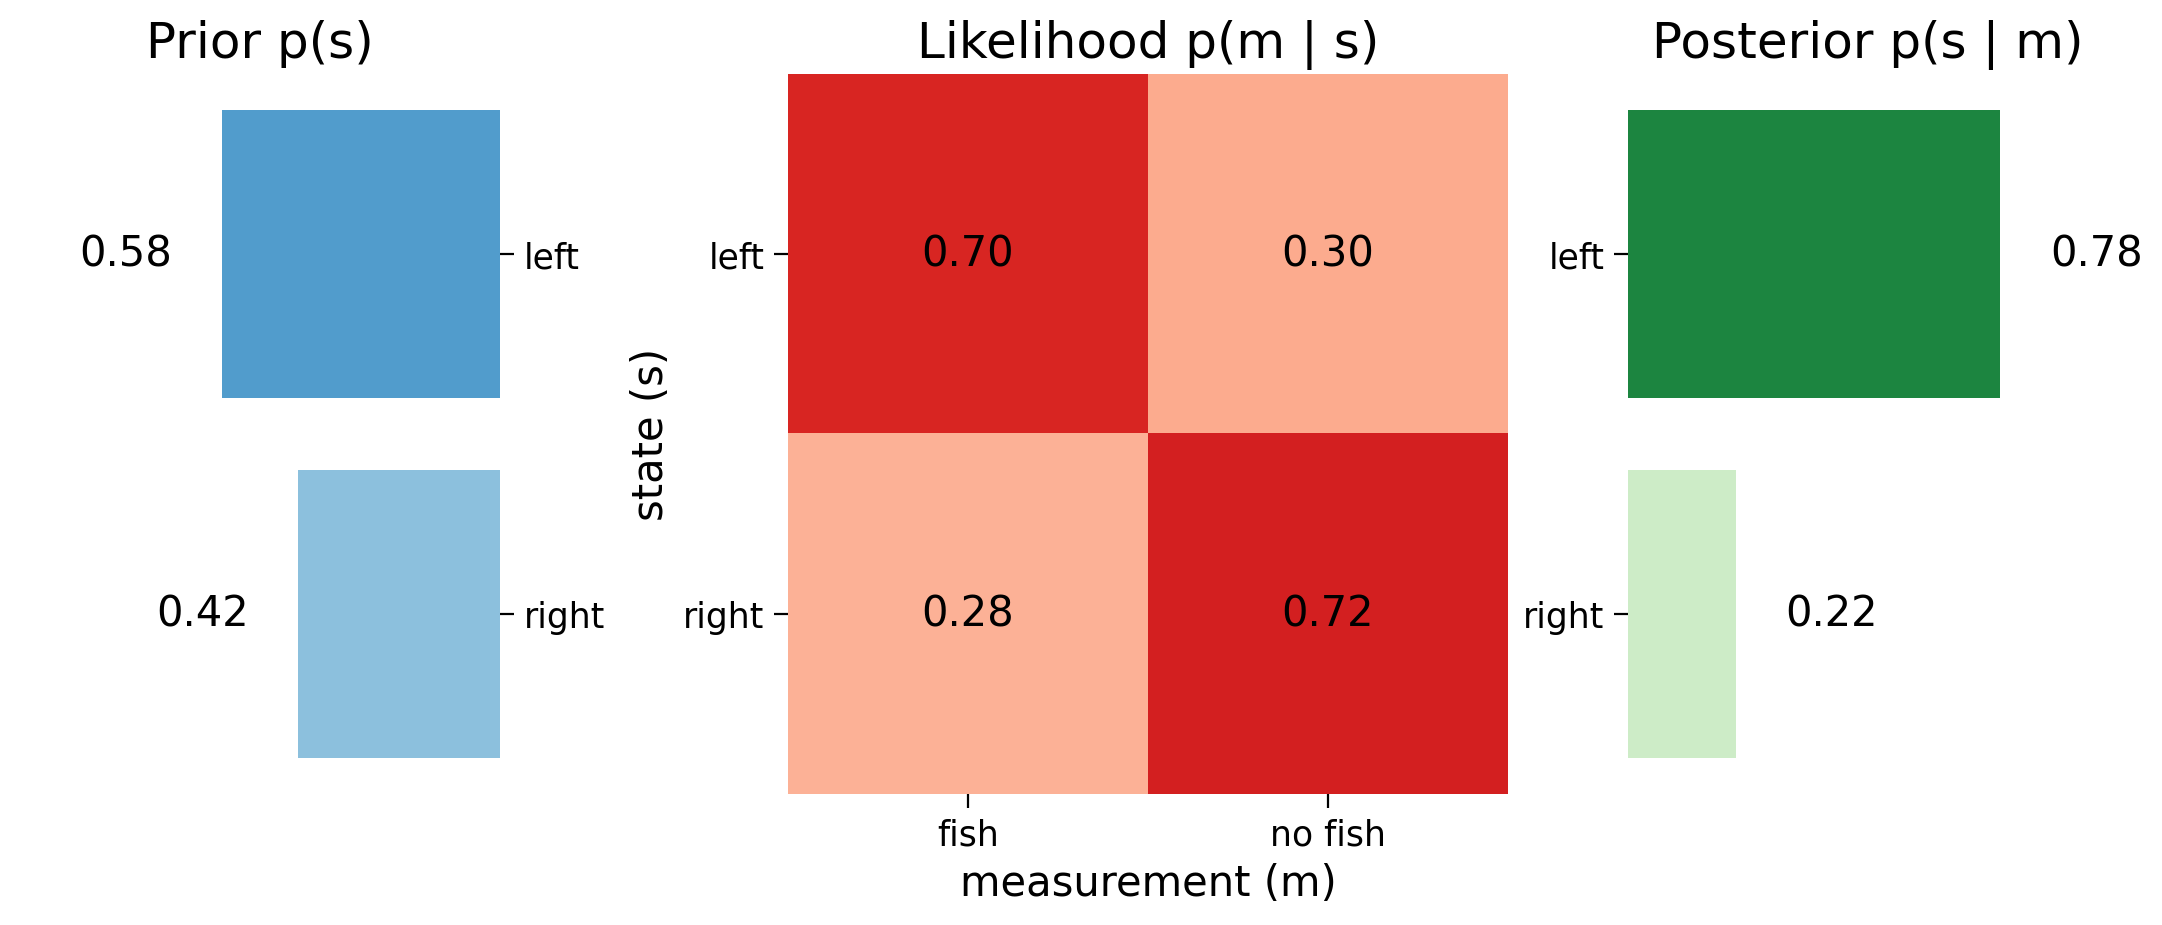

In [ ]:
# @markdown Execute this cell to enable the widget
# style = {'description_width': 'initial'}
ps_widget = widgets.FloatSlider(0.3, description='p(s = left)',
                                min=0.01, max=0.99, step=0.01)
p_a_s1_widget = widgets.FloatSlider(0.5, description='p(fish on left | state = left)',
                                    min=0.01, max=0.99, step=0.01, style=style, layout=Layout(width='370px'))
p_a_s0_widget = widgets.FloatSlider(0.1, description='p(fish on left | state = right)',
                                    min=0.01, max=0.99, step=0.01, style=style, layout=Layout(width='370px'))
# observed_widget = widgets.Checkbox(value=False, description='Observed fish (m)',
#                                  disabled=False, indent=False,
#                                  layout=Layout(display="flex", justify_content="center"))

observed_widget = ToggleButtons(options=['Fish', 'No Fish'],
    description='Observation (m) on the left:', disabled=False, button_style='',
    layout=Layout(width='auto', display="flex"),
    style={'description_width': 'initial'}
)

widget_ui = VBox([ps_widget,
                  HBox([p_a_s1_widget, p_a_s0_widget]),
                  observed_widget])
widget_out = interactive_output(plot_prior_likelihood,
                                {'ps': ps_widget,
                                'p_a_s1': p_a_s1_widget,
                                'p_a_s0': p_a_s0_widget,
                                'measurement': observed_widget})
display(widget_ui, widget_out)

# @widgets.interact(
#     ps=ps_widget,
#     p_a_s1=p_a_s1_widget,
#     p_a_s0=p_a_s0_widget,
#     m_right=observed_widget
# )
# def make_prior_likelihood_plot(ps,p_a_s1,p_a_s0,m_right):
#     fig = plot_prior_likelihood(ps,p_a_s1,p_a_s0,m_right)
#     plt.show(fig)
#     plt.close(fig)
#     return None

# Section 6: Making Bayesian fishing decisions



We will explore how to consider the expected utility of an action based on our belief (the posterior distribution) about where we think the fish are. Now we have all the components of a Bayesian decision: our prior information, the likelihood given a measurement, the posterior distribution (belief) and our utility (the gains and losses). This allows us to consider the relationship between the true value of the hidden state, $s$, and what we *expect* to get if we take action, $a$, based on our belief!

Let's use the following widget to think about the relationship between these probability distributions and utility function.

## Interactive Demo! 6: What is more important, the probabilities or the utilities?

We are now going to put everything we've learned together to gain some intuitions for how each of the elements that goes into a Bayesian decision comes together. Remember, the common assumption in neuroscience, psychology, economics, ecology, etc. is that we (humans and animals) are trying to maximize our expected utility. There is a lot going on in this demo as it brings everything in this tutorial together in one place - please spend time making sure you understand the controls and the plots, especially how everything relates together.

1. Can you find a situation where the expected utility is the same for both actions?
2. What is more important for determining the expected utility: the prior or a new measurement (the likelihood)?
3. Why is this a normative model?
4. Can you think of ways in which this model would need to be extended to describe human or animal behavior?

*`+8 points`*

Output()

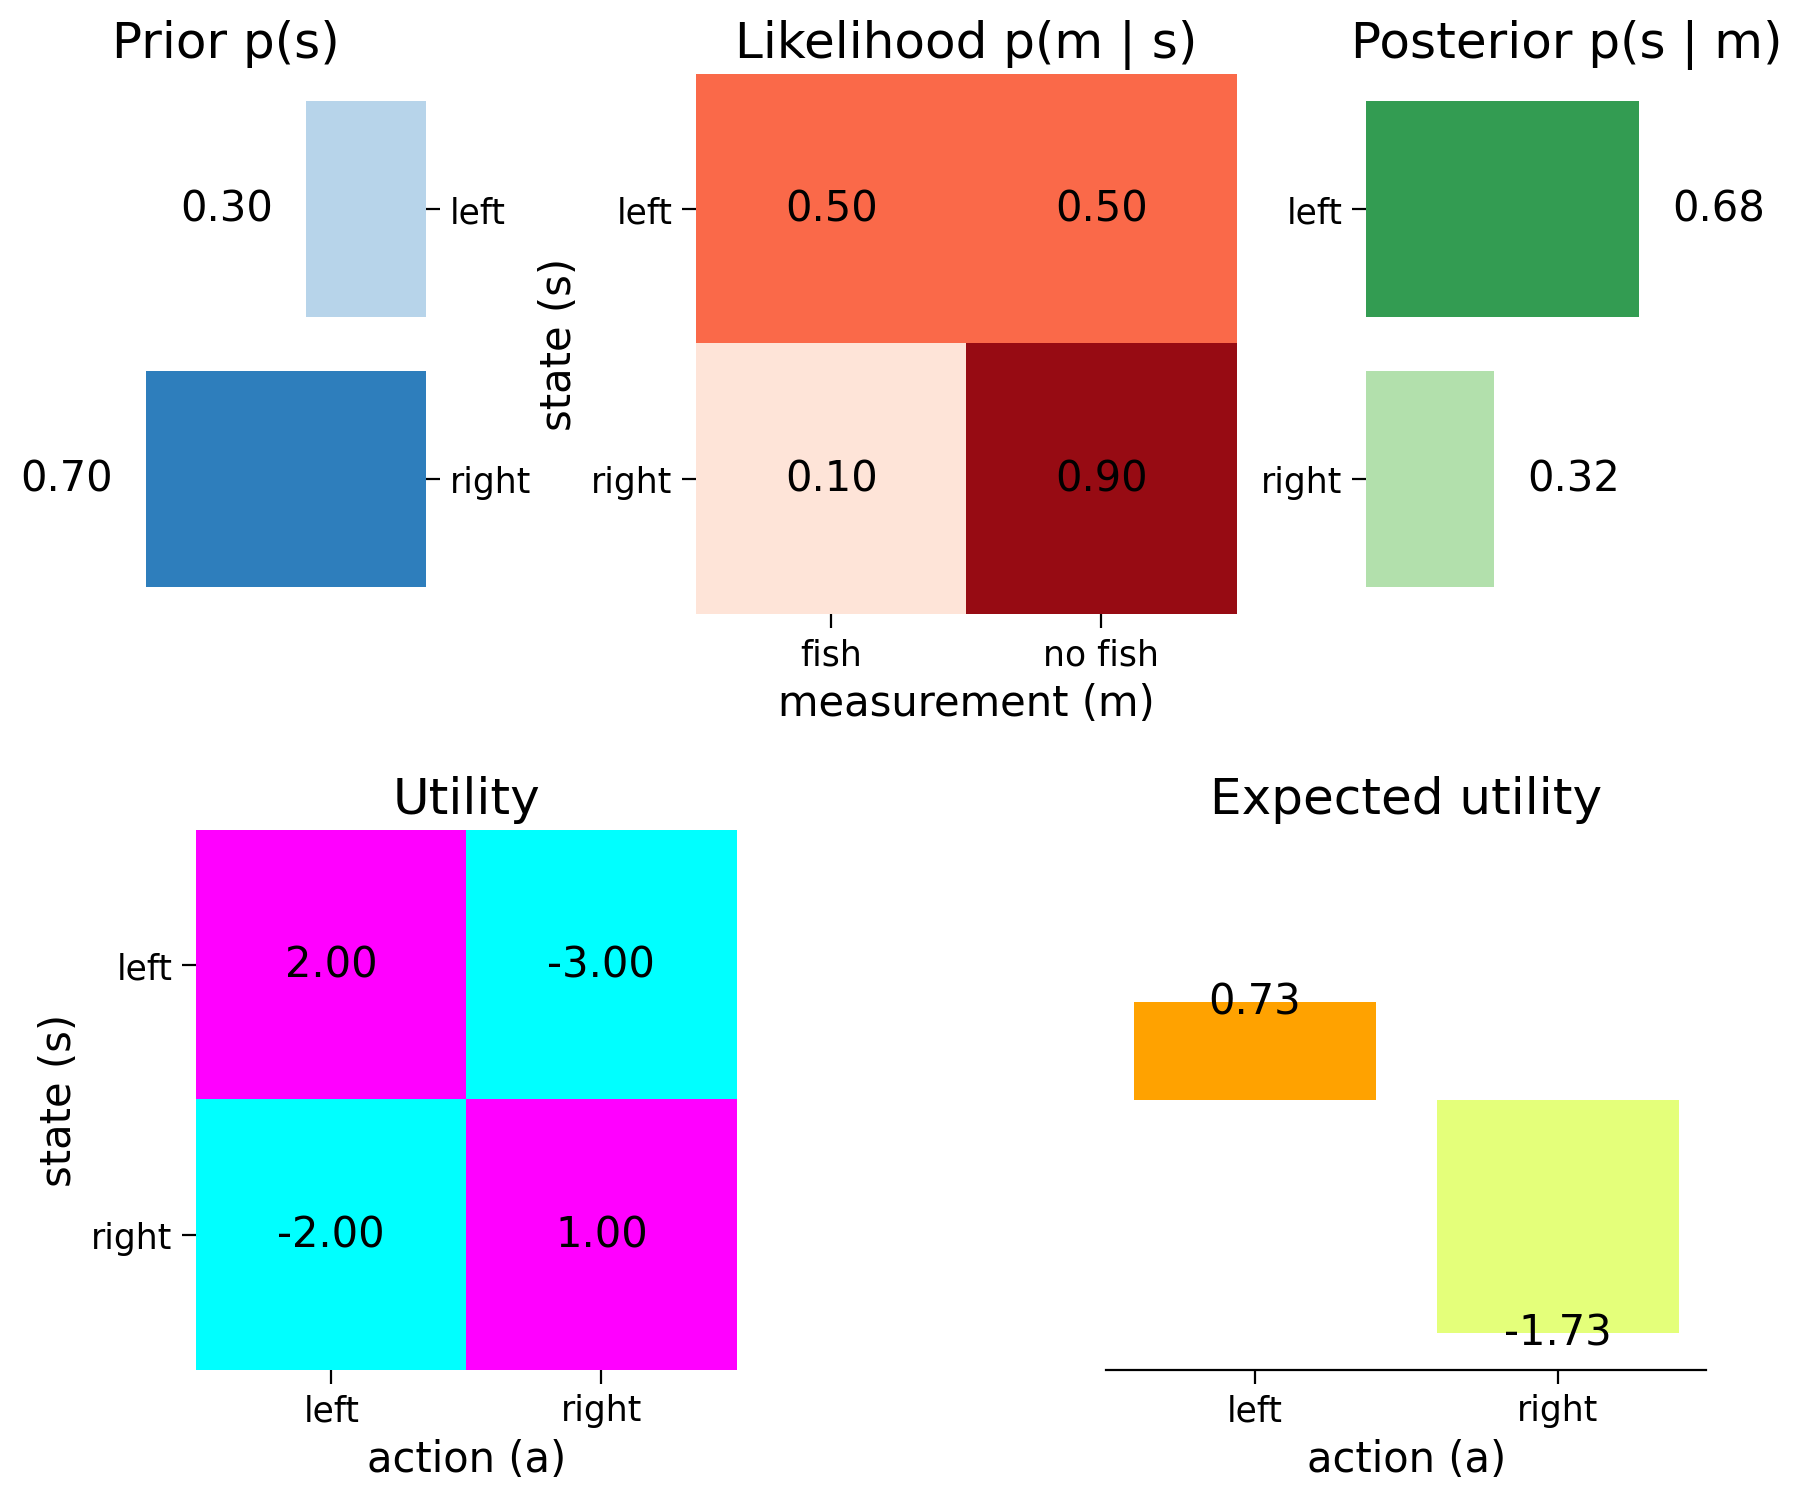

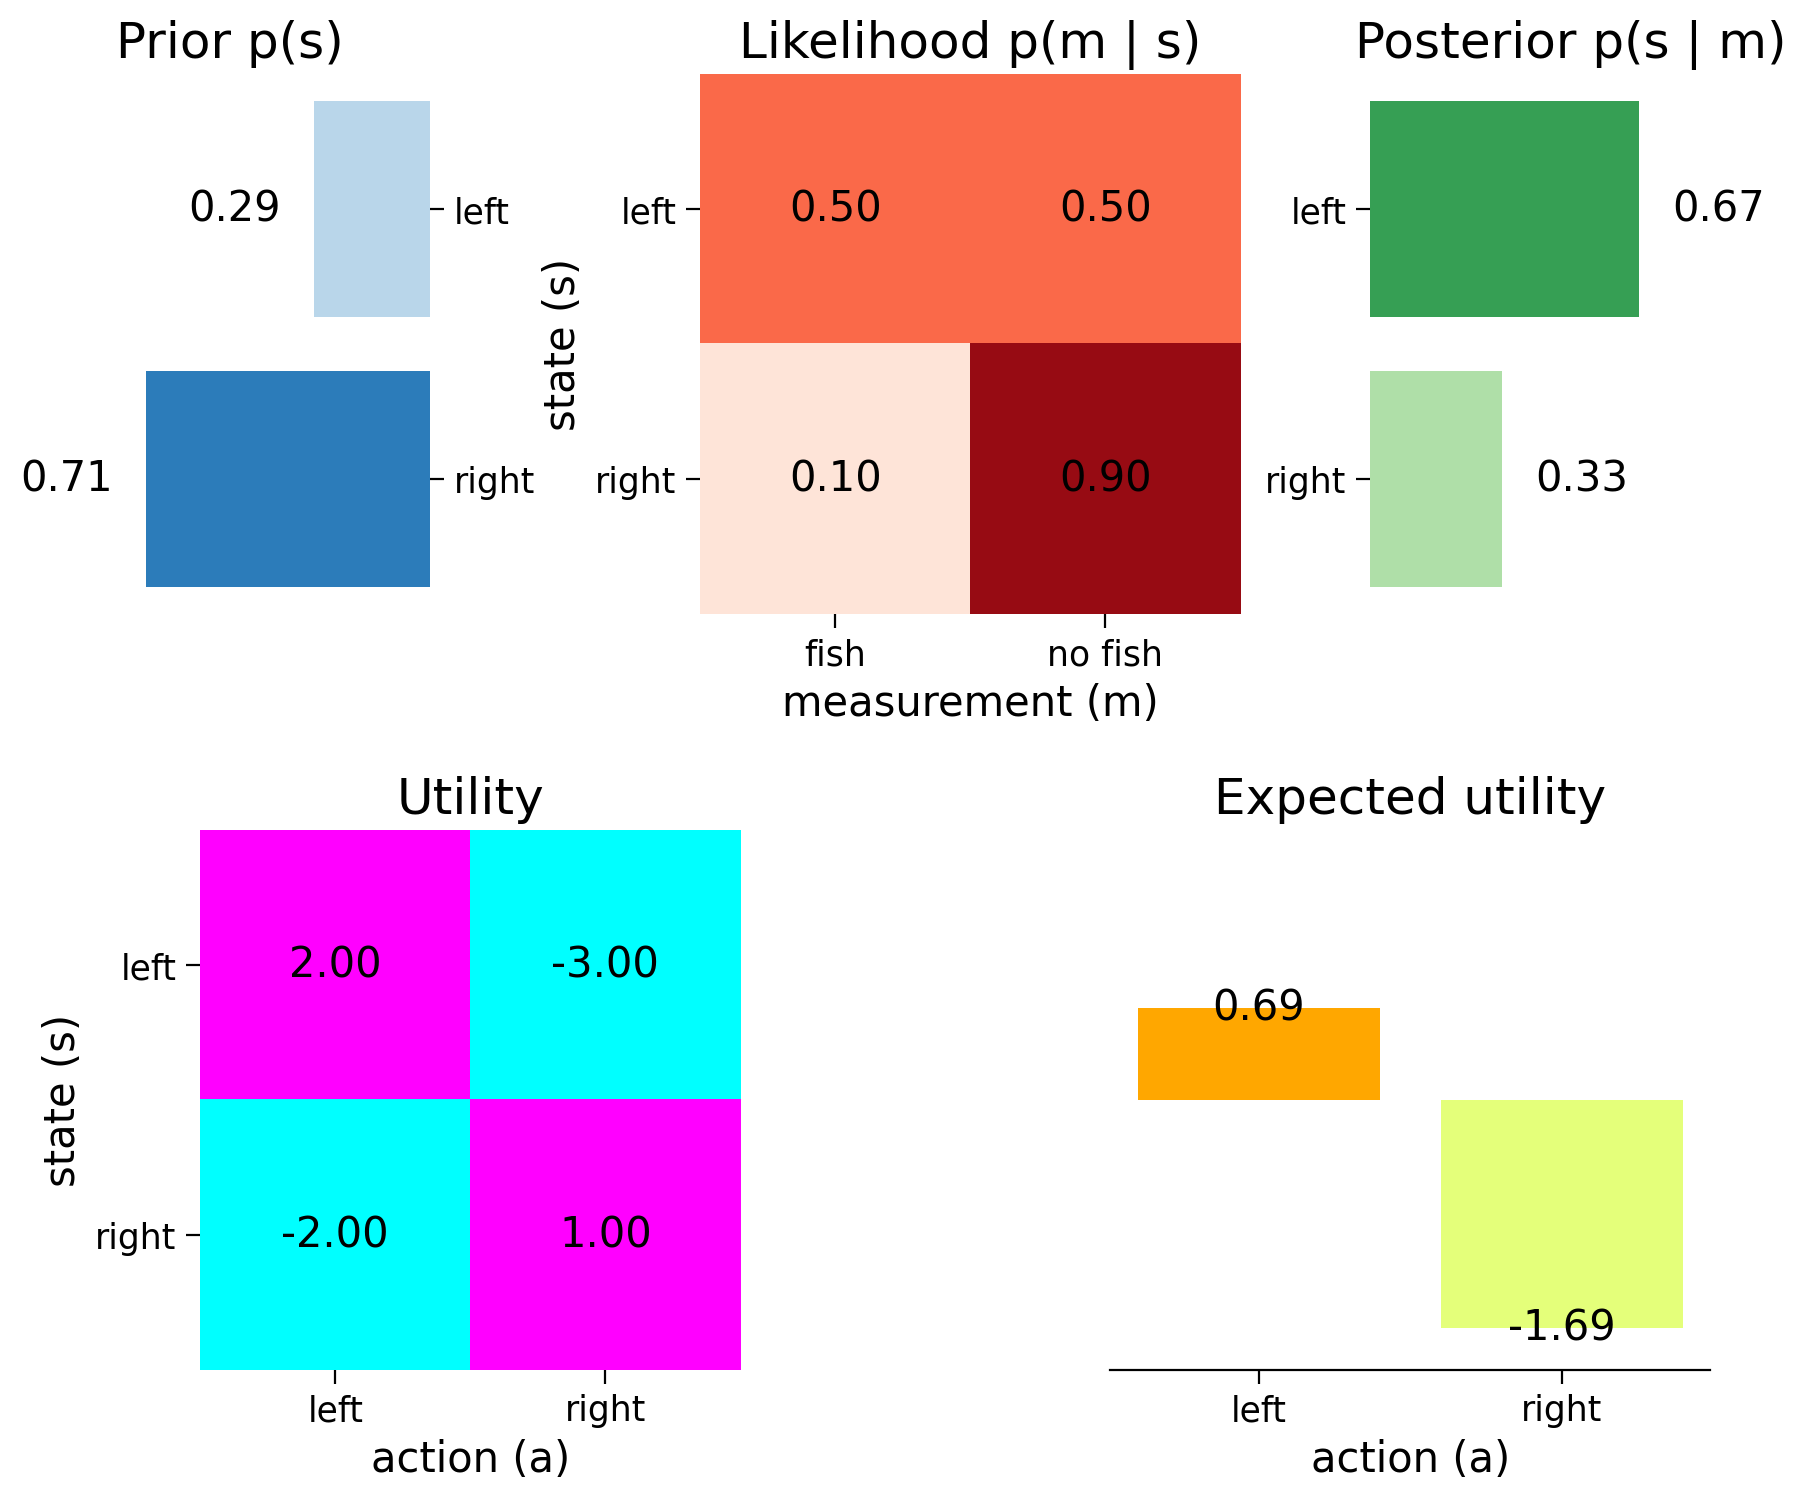

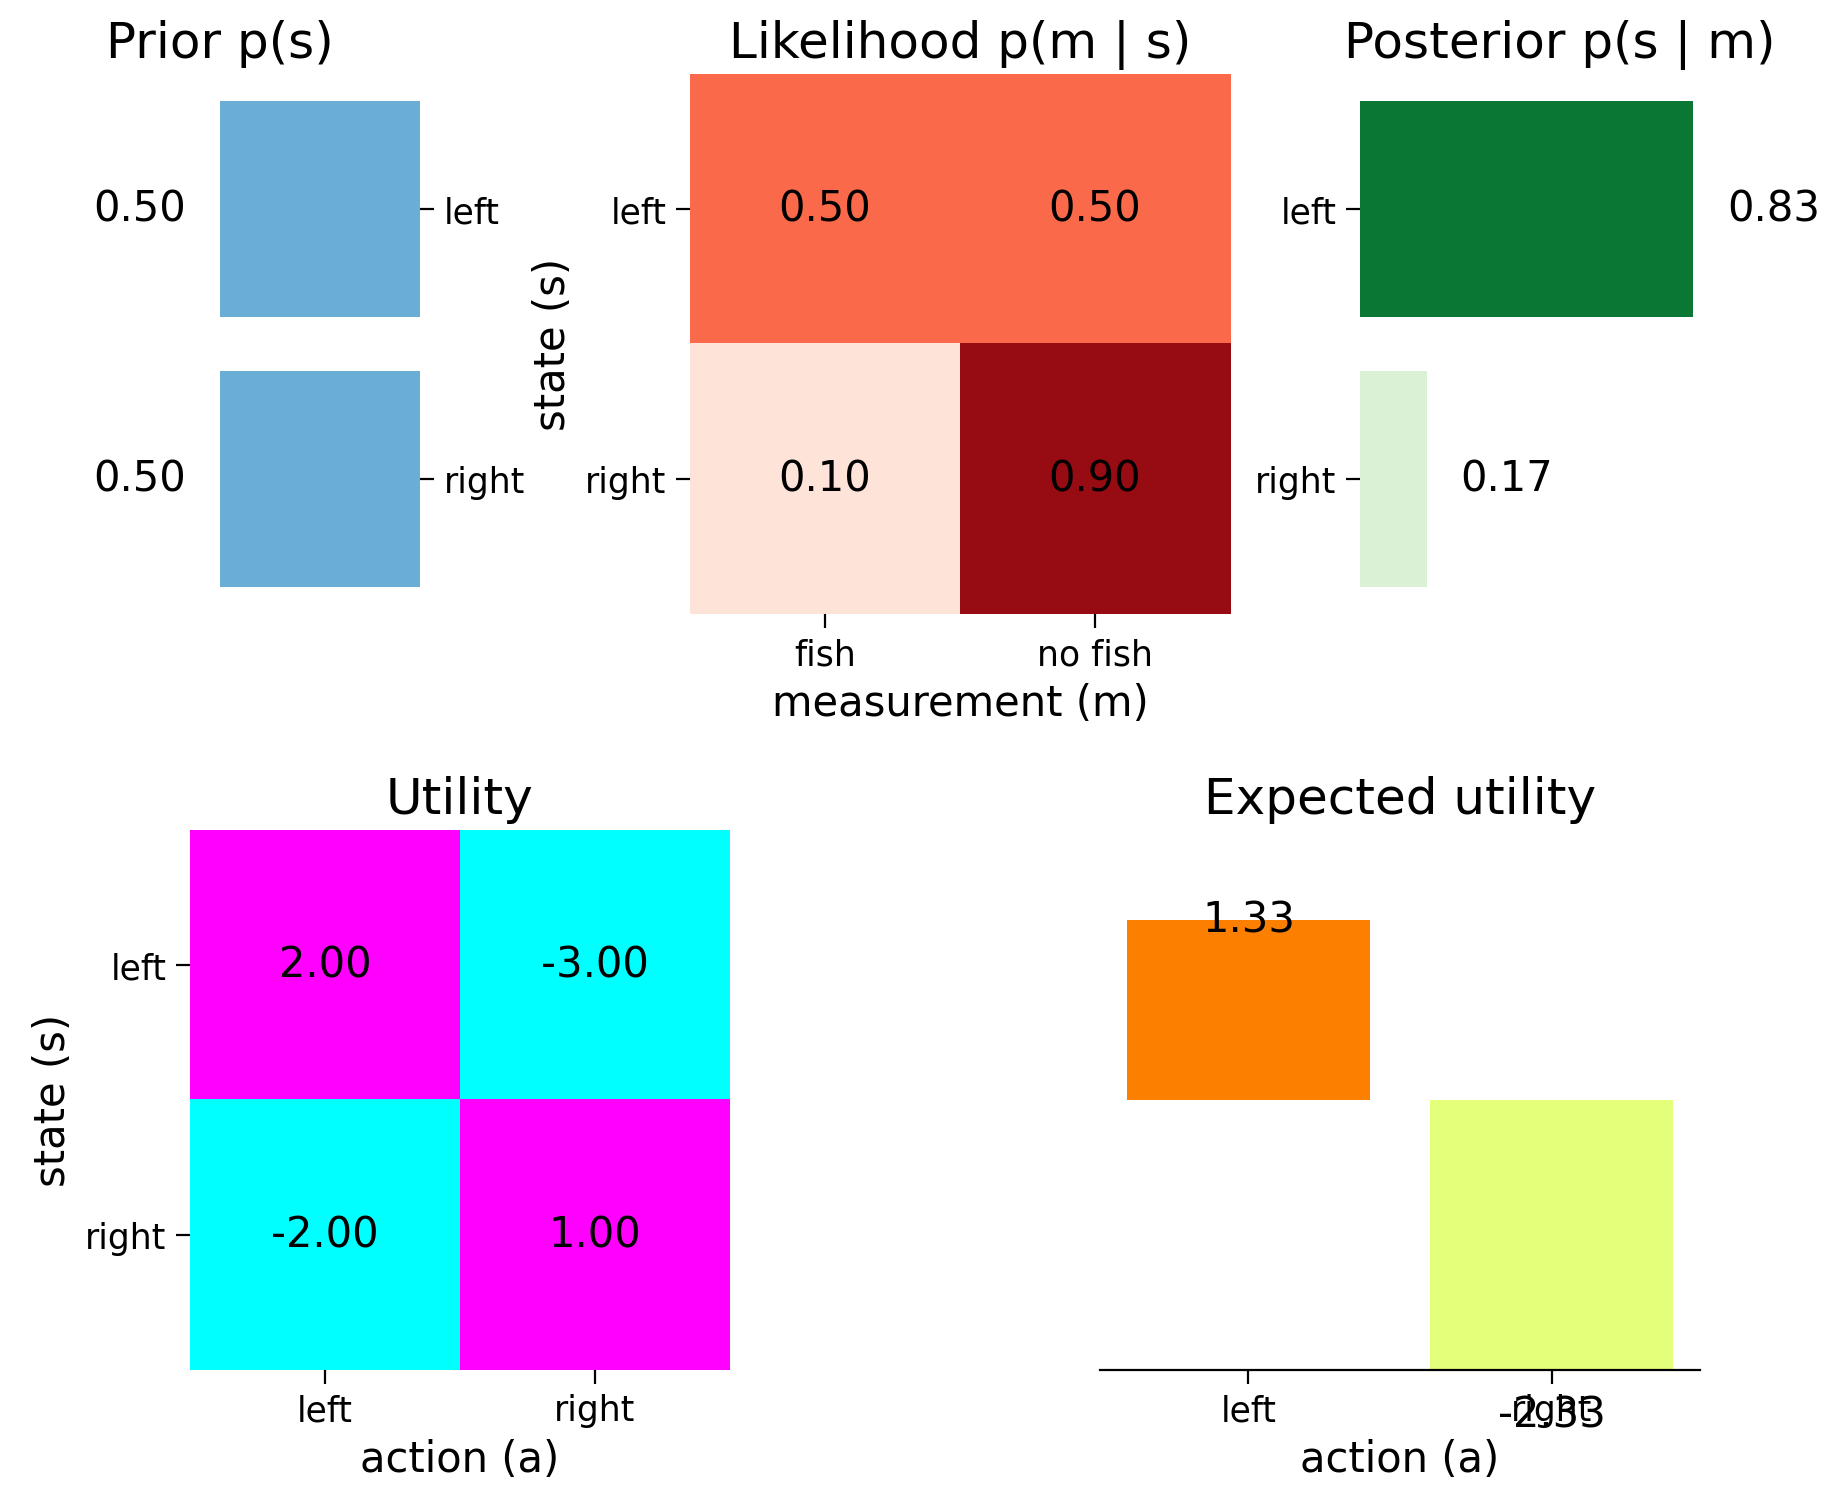

In [ ]:
# @markdown Execute this cell to enable the widget
# style = {'description_width': 'initial'}

ps_widget = widgets.FloatSlider(0.3, description='p(s = left)',
                                min=0.01, max=0.99, step=0.01, layout=Layout(width='300px'))
p_a_s1_widget = widgets.FloatSlider(0.5, description='p(fish on left | state = left)',
                                    min=0.01, max=0.99, step=0.01, style=style, layout=Layout(width='370px'))
p_a_s0_widget = widgets.FloatSlider(0.1, description='p(fish on left | state = right)',
                                    min=0.01, max=0.99, step=0.01, style=style, layout=Layout(width='370px'))

observed_widget = ToggleButtons(options=['Fish', 'No Fish'],
    description='Observation (m) on the left:', disabled=False, button_style='',
    layout=Layout(width='auto', display="flex"),
    style={'description_width': 'initial'}
)

widget_ui = VBox([ps_widget,
                  HBox([p_a_s1_widget, p_a_s0_widget]),
                  observed_widget])

widget_out = interactive_output(plot_prior_likelihood_utility,
                                {'ps': ps_widget,
                                'p_a_s1': p_a_s1_widget,
                                'p_a_s0': p_a_s0_widget,
                                'measurement': observed_widget})
display(widget_ui, widget_out)

# @widgets.interact(
#     ps=ps_widget,
#     p_a_s1=p_a_s1_widget,
#     p_a_s0=p_a_s0_widget,
#     m_right=observed_widget
# )
# def make_prior_likelihood_utility_plot(ps, p_a_s1, p_a_s0,m_right):
#     fig = plot_prior_likelihood_utility(ps, p_a_s1, p_a_s0,m_right)
#     plt.show(fig)
#     plt.close(fig)
#     return None